In [ ]:
# !pip install u8darts[all] -q

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from darts import TimeSeries
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.utils import SeasonalityMode

import time
import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Darts core modules
from darts import TimeSeries
from darts.models import TCNModel

# Data preprocessing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from sklearn.preprocessing import MinMaxScaler

# Seasonality and trend
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.utils.statistics import (
    check_seasonality,
    extract_trend_and_seasonality,
    granger_causality_tests,
    stationarity_test_adf,
    stationarity_test_kpss,
    stationarity_tests,
    plot_acf,
    plot_ccf,
    plot_hist,
    plot_pacf,
    plot_residuals_analysis
)

# Decomposition from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns


In [11]:
aqaba = pd.read_csv('Datasets-Ready\\Aqaba_Ready.csv', index_col=0)
ghor = pd.read_csv('Datasets-Ready\\Ghor EL Safi_Ready.csv', index_col=0)
irbid = pd.read_csv('Datasets-Ready\\Irbid_Ready.csv', index_col=0)
irwaished = pd.read_csv('Datasets-Ready\\Irwaished_Ready.csv', index_col=0)
maan = pd.read_csv('Datasets-Ready\\Maan_Ready.csv', index_col=0)
mafraq = pd.read_csv('Datasets-Ready\\Mafraq_Ready.csv', index_col=0)
amman = pd.read_csv('Datasets-Ready\\Queen Alia Airport_Ready.csv', index_col=0)
safawi = pd.read_csv('Datasets-Ready\\Safawi_Ready.csv', index_col=0)

In [12]:
df =aqaba.copy()
df.head()

Air Dew Point  Air Temperature (OC)  Humidity %  \
2000-01-01 00:00:00            6.7                  14.9   57.968356   
2000-01-01 01:00:00            7.0                  15.0   58.794057   
2000-01-01 02:00:00            7.0                  15.0   58.794057   
2000-01-01 03:00:00            6.5                  15.2   56.084410   
2000-01-01 04:00:00            7.0                  15.0   58.794057   

                     Atmospheric Pressure  Wind_U  Wind_V  
2000-01-01 00:00:00           1014.200012     0.0    -1.5  
2000-01-01 01:00:00           1014.200012     0.0    -0.0  
2000-01-01 02:00:00           1014.200012     0.0    -0.0  
2000-01-01 03:00:00           1013.900024     0.0    -1.5  
2000-01-01 04:00:00           1013.900024     0.0    -1.5

In [27]:
df.index = pd.to_datetime(df.index)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 2000-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Air Dew Point         210384 non-null  float64
 1   Air Temperature (OC)  210384 non-null  float64
 2   Humidity %            210384 non-null  float64
 3   Atmospheric Pressure  210384 non-null  float64
 4   Wind_U                210384 non-null  float64
 5   Wind_V                210384 non-null  float64
dtypes: float64(6)
memory usage: 19.3+ MB


<Axes: xlabel='time'>

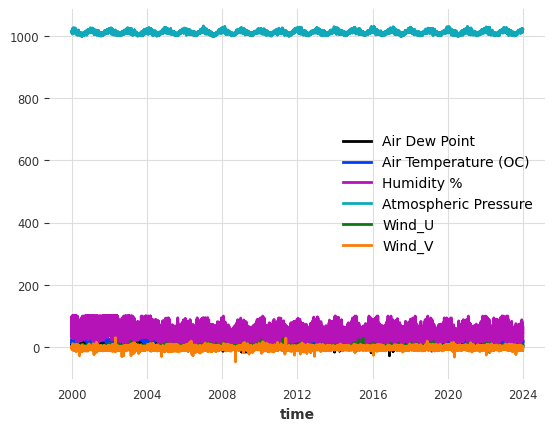

In [28]:
value_filler = MissingValuesFiller()
series = value_filler.transform(TimeSeries.from_dataframe(df),fill_missing_dates=True, freq='h')
series.plot()

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
series_scaled = transformer.fit_transform(series)

train, test = series_scaled.split_after(0.8)

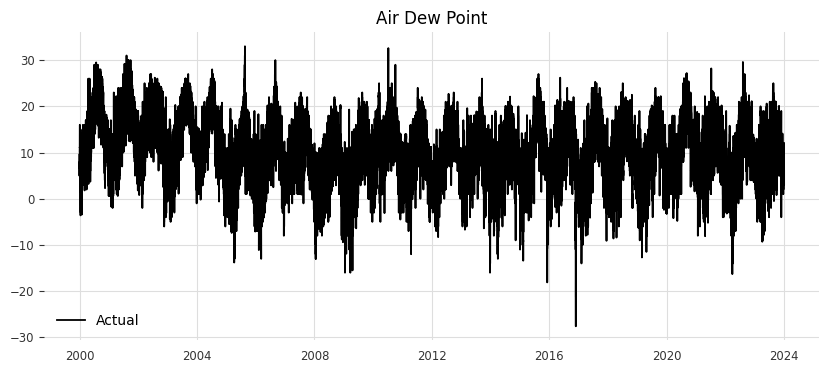

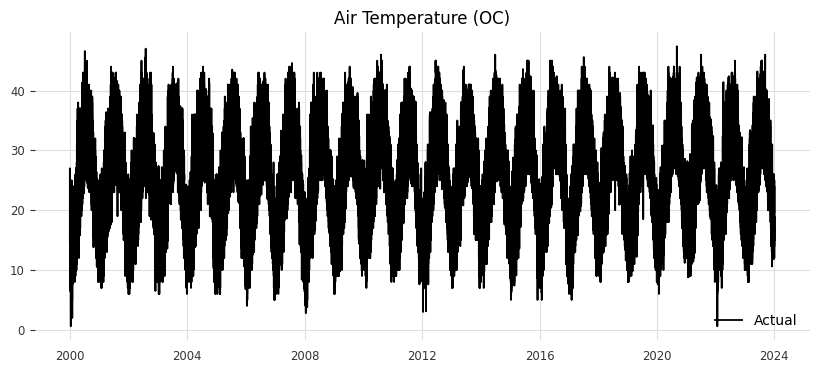

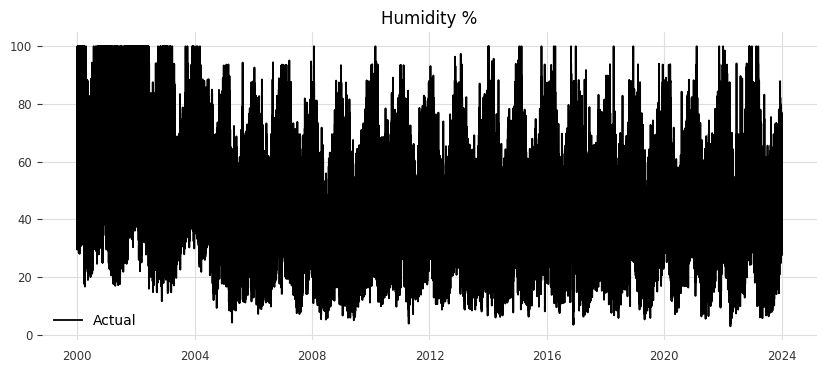

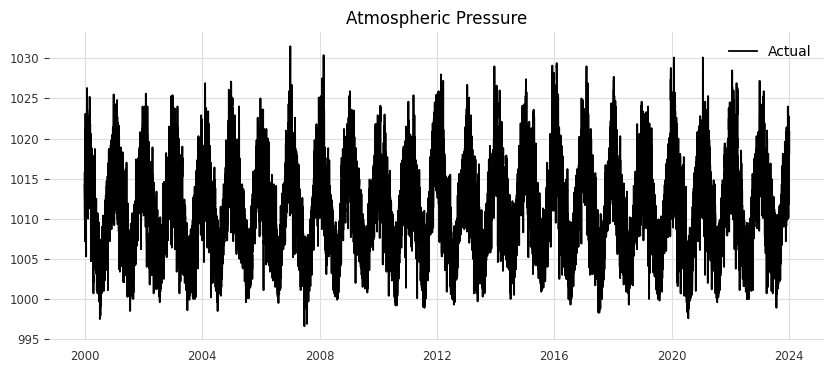

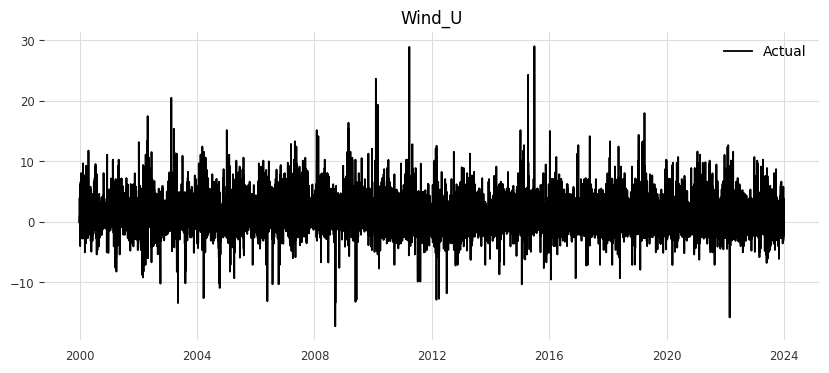

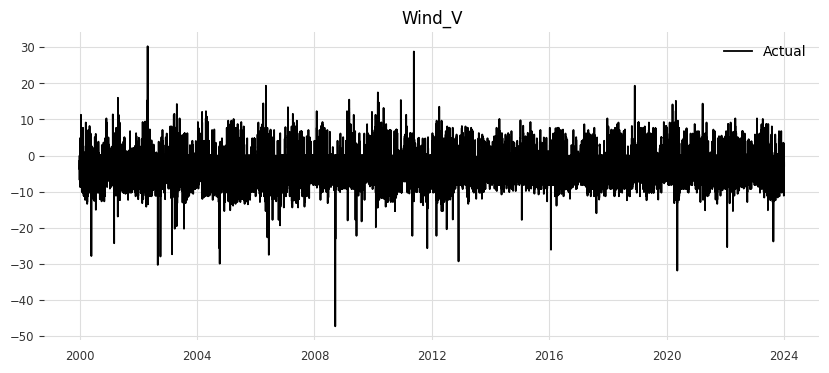

In [31]:
for col in series.components:
    plt.figure(figsize=(10, 4))
    plt.plot( series.to_dataframe().index,  series.to_dataframe()[col], label='Actual')
    plt.title(f'{col}')
    plt.legend()
    plt.grid(True)
    plt.show()

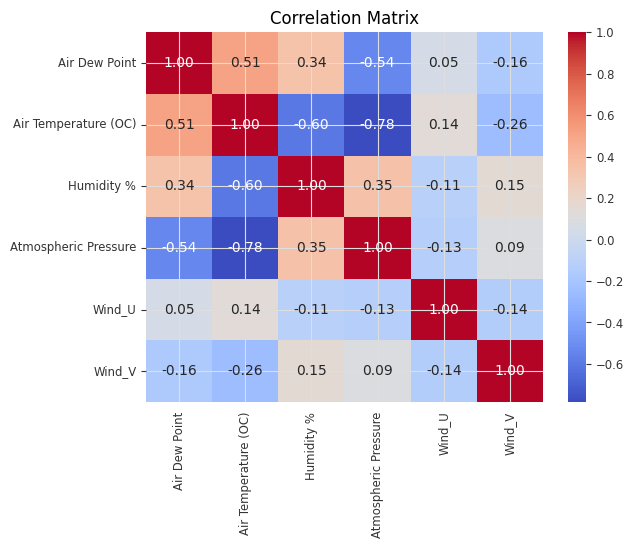

In [43]:
# Correlation heatmap
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [32]:
# ——— Configuration ———
HIST_BINS       = 30
GRANGER_MAXLAG  = 24
CCF_MAX_LAG     = 48
PACF_MAX_LAG    = 24
DECOMP_PERIOD   = 365
STL_FREQS       = [24, 168]            # hourly → daily + weekly
STL_METHOD      = 'MSTL'
STL_MODEL       = ModelMode.ADDITIVE
SLICE_2Y_START  = pd.to_datetime("2015-01-01")
SLICE_2Y_END    = pd.to_datetime("2017-12-31")

In [ ]:
def plot_seasonal_decompose(df: pd.Series, col: str):

    """Converts the time series to daily frequency using mean aggregation, then plot seasonal decomposition of a time series using statsmodels."""
    
    daily = df.resample('D').mean()
    decomp = seasonal_decompose(daily, model='additive', period=DECOMP_PERIOD)
    fig = decomp.plot()
    fig.suptitle(f"{col} — Seasonal Decomposition")
    plt.tight_layout()
    plt.show()

In [36]:
def plot_stl(series: TimeSeries, col: str):

    """Plots the STL (Seasonal-Trend decomposition using LOESS) decomposition of a time series using Darts."""
    
    trend, seasonal = extract_trend_and_seasonality(
        series[col],
        freq=STL_FREQS,
        model=STL_MODEL,
        method=STL_METHOD
    )
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    series[col].plot(label="Original", ax=axes[0])
    axes[0].legend()
    trend.plot(label="Trend", ax=axes[1])
    axes[1].legend()
    seasonal.plot(label="Seasonality", ax=axes[2])
    axes[2].legend()
    fig.suptitle(f"{col} — STL Decomposition")
    plt.tight_layout()
    plt.show()


In [37]:
def run_granger_and_ccf(series: TimeSeries, col: str, components: list):
    
    """
    Runs Granger causality tests (that checks whether past values of other can predict col) to explore causal relationships 
    and plots the cross-correlation function (CCF) that shows correlations at various lags for the given column against all other columns.
    note that low p-values suggest 'other' Granger-causes 'col'
    """
    
    for other in components:
        if other == col:
            continue
        print(f"\nCausality tests: {other} → {col}")
        results = granger_causality_tests(series[col], series[other],
                                          maxlag=GRANGER_MAXLAG,
                                          addconst=True)
        for lag, (test_stat, _) in results.items():
            print(f"  Lag {lag:2d} → p-value: {test_stat['ssr_ftest'][1]:.4f}")
        plot_ccf(series[col], series[other], max_lag=CCF_MAX_LAG, m=24)
        plt.title(f"{col} ↔ {other} — CCF")
        plt.show()

In [38]:
def analyze_component(series: TimeSeries, df: pd.DataFrame, col: str, components: list):
    
    """
    This is the main orchestrating function for analyzing a single component/variable.
    1- Extracts the first 2 years of data for visual inspection.
    2- Plots the distribution of the values.
    3- Checks for seasonality and prints the period.
    4- Performs classical decomposition and STL decomposition.
    5- Runs Granger causality tests and plots the cross-correlation function (CCF).
    6- Plots the ACF (Autocorrelation Function (how values relate to their own lags)) 
    7- Plots the PACF (Partial ACF (removes indirect effects))
    8- Performs stationarity tests: 
        -ADF (Null hypothesis = non-stationary (want low p-value)
        -KPSS (Null hypothesis = stationary (want high p-value)
        -Combined stationarity test (ADF + KPSS) to determine overall stationarity
    """
    print("\n\n***********************************************************************************")
    print(f"===== Analyzing '{col}' 📈 =====")
    
    # # 1) 2-year seasonal slice
    t0     = series.start_time()
    t_cut  = t0 + timedelta(days=365 * 2)
    ts2y   = series.slice(t0, t_cut)

    plt.figure(figsize=(10, 3))
    ts2y[col].plot(label=col)
    plt.title(f"{col} ({t0.date()} → {t_cut.date()})")
    plt.tight_layout()
    plt.show()

    # 2) Histogram
    plot_hist(series[col], bins=HIST_BINS, density=True, title=f"{col} — Distribution")

    # 3) Seasonality check
    seasonal, period = check_seasonality(series[col])
    print(f"Seasonal? {seasonal}, Period = {period}")

    # 4) Classical decomposition
    plot_seasonal_decompose(df[col], col)

    # 5) STL decomposition
    plot_stl(series, col)

    # 6) Granger causality + CCF
    run_granger_and_ccf(series, col, components)

    # 7) ACF & PACF
    plot_acf(series[col], max_lag=CCF_MAX_LAG, alpha=0.05, m=24)
    plt.title(f"{col} — ACF")
    plt.show()
    plot_pacf(series[col], max_lag=PACF_MAX_LAG, method='ywadjusted', alpha=0.05, fig_size=(10, 4))
    plt.title(f"{col} — PACF")
    plt.show()

    # 8) Stationarity tests
    adf_stat, adf_pval, adf_lags, adf_nobs, adf_crit, _ = stationarity_test_adf(series[col])
    kpss_stat, kpss_pval, kpss_lags, kpss_crit = stationarity_test_kpss(series[col])
    combined_stationary = stationarity_tests(series[col])

    # Nicely print
    print("The following tests were performed to determine the stationarity of:", col)
    print(f"— ADF Test —")
    print(f"Statistic: {adf_stat:.4f}")
    print(f"p-value:   {adf_pval:.4g}")
    print(f"Lags:      {adf_lags}, Observations: {adf_nobs}")
    print("Critical values:")
    for level, cv in adf_crit.items():
        print(f"  {level}: {cv:.4f}")

    print("\n— KPSS Test —")
    print(f"Statistic: {kpss_stat:.4f}")
    print(f"p-value:   {kpss_pval:.4g}")
    print(f"Lags:      {kpss_lags}")
    print("Critical values:")
    for level, cv in kpss_crit.items():
        print(f"  {level}: {cv:.3f}")

    print(f"\nOverall stationary? {combined_stationary} ✅")
    print("***********************************************************************************\n\n")



***********************************************************************************
===== Analyzing 'Air Dew Point' 📈 =====


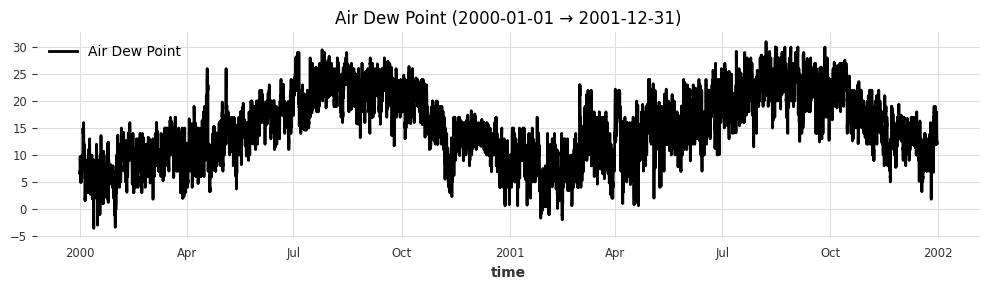

Seasonal? False, Period = 0


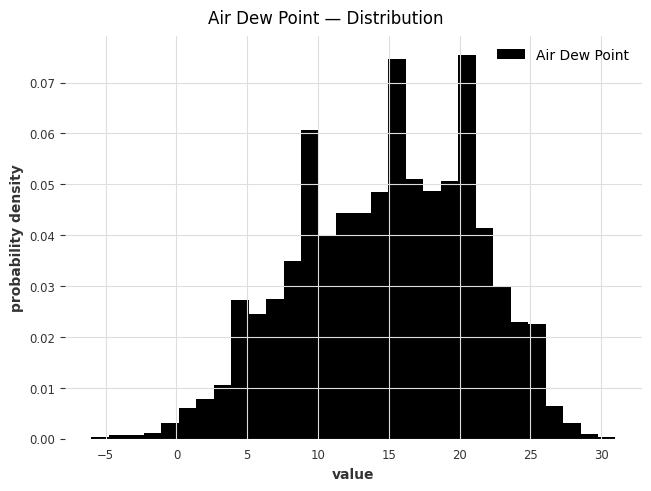

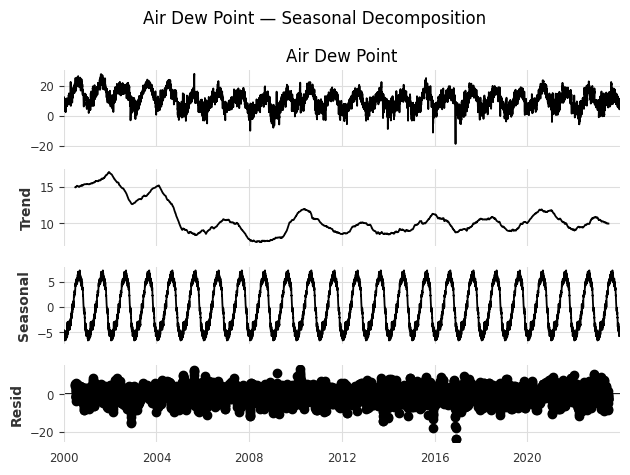

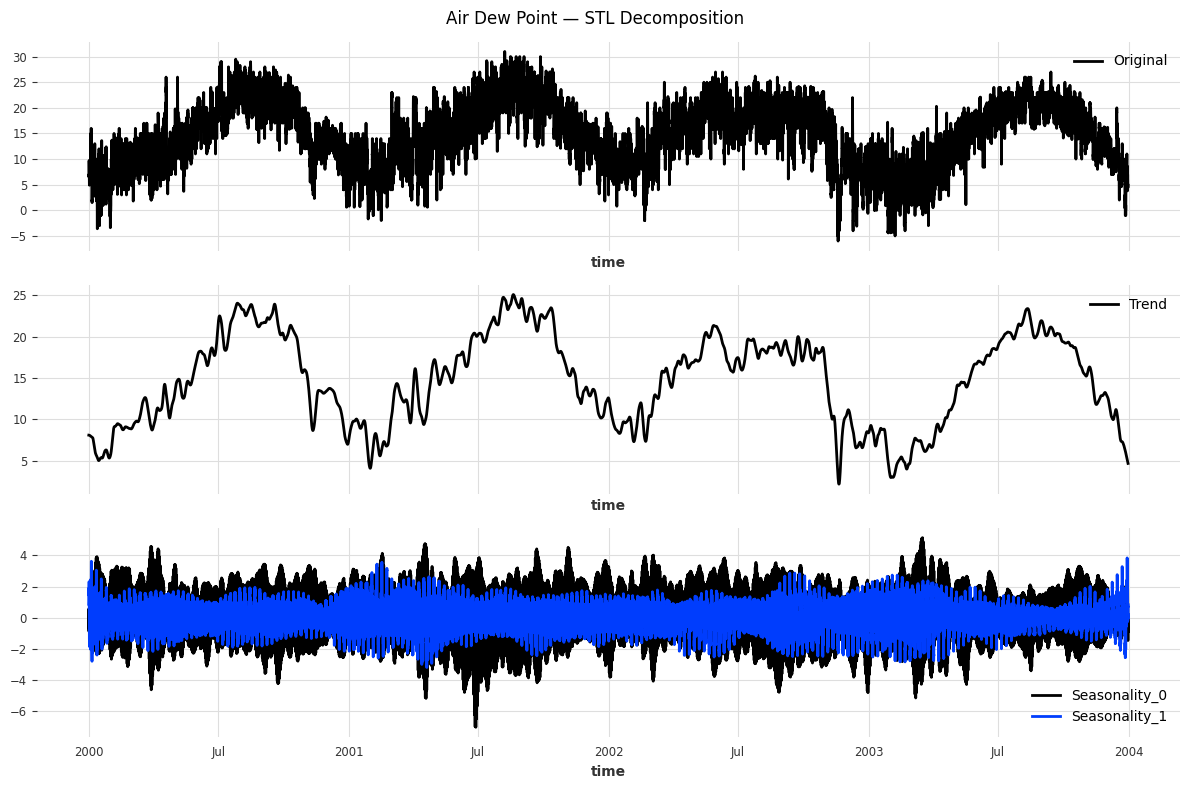


Causality tests: Air Temperature (OC) → Air Dew Point


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1442.6666, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=1442.7902, p=0.0000  , df=1
likelihood ratio test: chi2=1413.8774, p=0.0000  , df=1
parameter F test:         F=1442.6666, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=680.6277, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=1361.4497, p=0.0000  , df=2
likelihood ratio test: chi2=1335.6657, p=0.0000  , df=2
parameter F test:         F=680.6277, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=492.6789, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=1478.3320, p=0.0000  , df=3
likelihood ratio test: chi2=1447.9953, p=0.0000  , df=3
parameter F test:         F=492.6789, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=

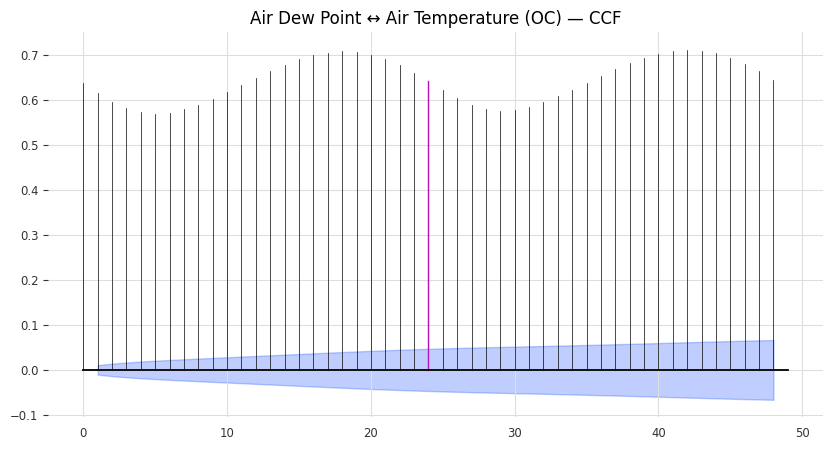


Causality tests: Humidity % → Air Dew Point


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=472.4474, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=472.4879, p=0.0000  , df=1
likelihood ratio test: chi2=469.3307, p=0.0000  , df=1
parameter F test:         F=472.4474, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=759.2087, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=1518.6341, p=0.0000  , df=2
likelihood ratio test: chi2=1486.6454, p=0.0000  , df=2
parameter F test:         F=759.2087, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=764.3857, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=2293.6154, p=0.0000  , df=3
likelihood ratio test: chi2=2221.6677, p=0.0000  , df=3
parameter F test:         F=764.3857, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=704.

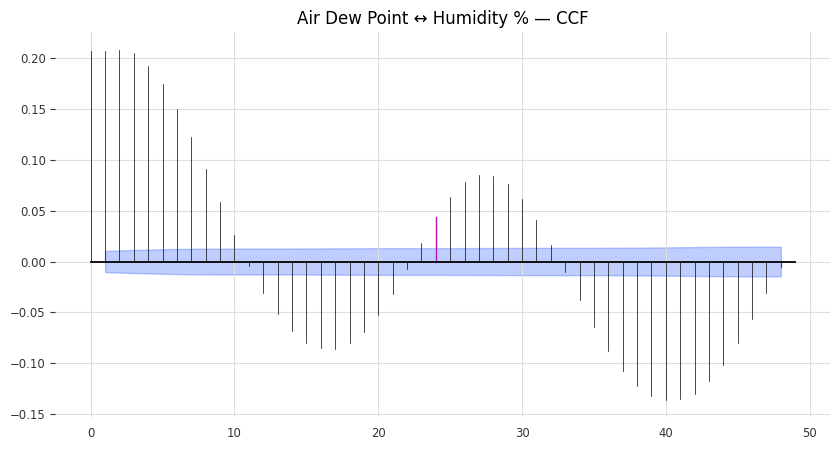


Causality tests: Atmospheric Pressure → Air Dew Point


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=347.6623, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=347.6921, p=0.0000  , df=1
likelihood ratio test: chi2=345.9784, p=0.0000  , df=1
parameter F test:         F=347.6623, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=292.8292, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=585.7419, p=0.0000  , df=2
likelihood ratio test: chi2=580.8999, p=0.0000  , df=2
parameter F test:         F=292.8292, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=217.6811, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=653.1737, p=0.0000  , df=3
likelihood ratio test: chi2=647.1602, p=0.0000  , df=3
parameter F test:         F=217.6811, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=162.6524

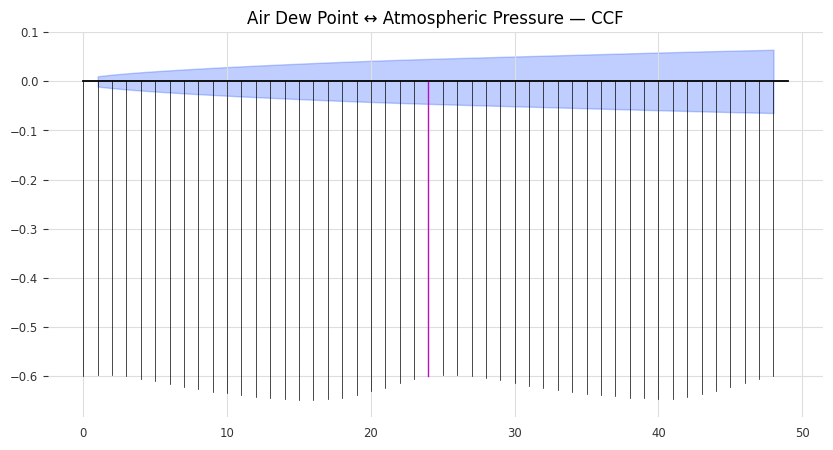


Causality tests: Wind_U → Air Dew Point


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=83.8841 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=83.8913 , p=0.0000  , df=1
likelihood ratio test: chi2=83.7910 , p=0.0000  , df=1
parameter F test:         F=83.8841 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=33.9477 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=67.9051 , p=0.0000  , df=2
likelihood ratio test: chi2=67.8394 , p=0.0000  , df=2
parameter F test:         F=33.9477 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.9953 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=62.9985 , p=0.0000  , df=3
likelihood ratio test: chi2=62.9420 , p=0.0000  , df=3
parameter F test:         F=20.9953 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.2761 

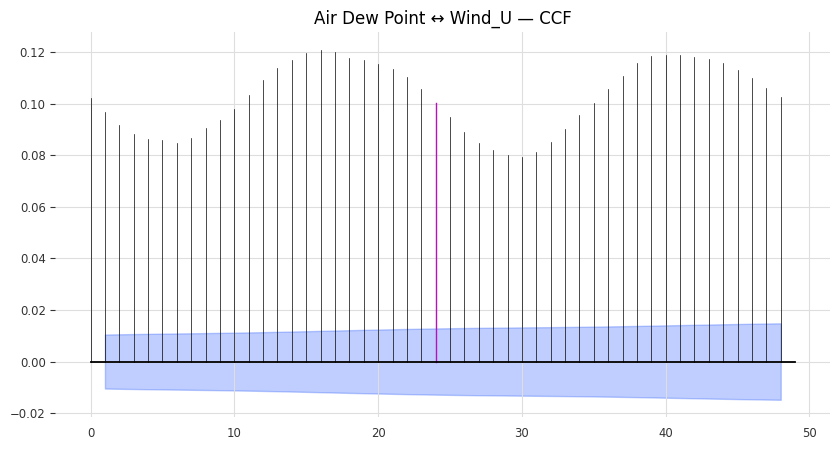


Causality tests: Wind_V → Air Dew Point


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=311.3365, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=311.3632, p=0.0000  , df=1
likelihood ratio test: chi2=309.9879, p=0.0000  , df=1
parameter F test:         F=311.3365, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=143.8264, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=287.6938, p=0.0000  , df=2
likelihood ratio test: chi2=286.5192, p=0.0000  , df=2
parameter F test:         F=143.8264, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=97.6430 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=292.9875, p=0.0000  , df=3
likelihood ratio test: chi2=291.7694, p=0.0000  , df=3
parameter F test:         F=97.6430 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=73.5226 

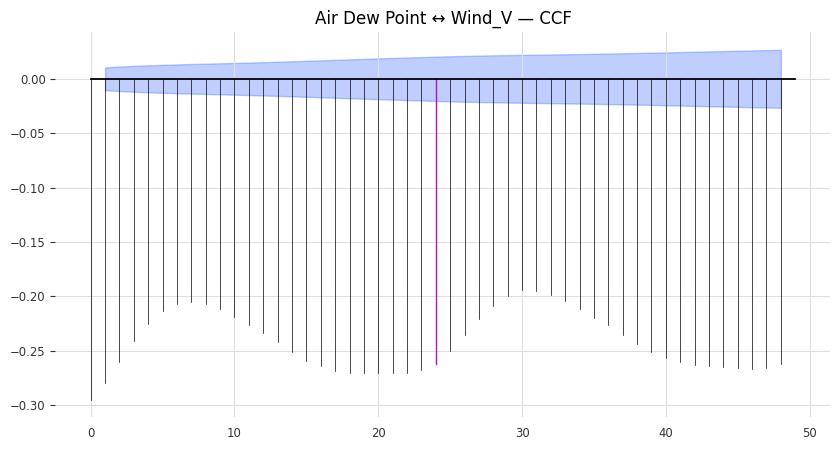

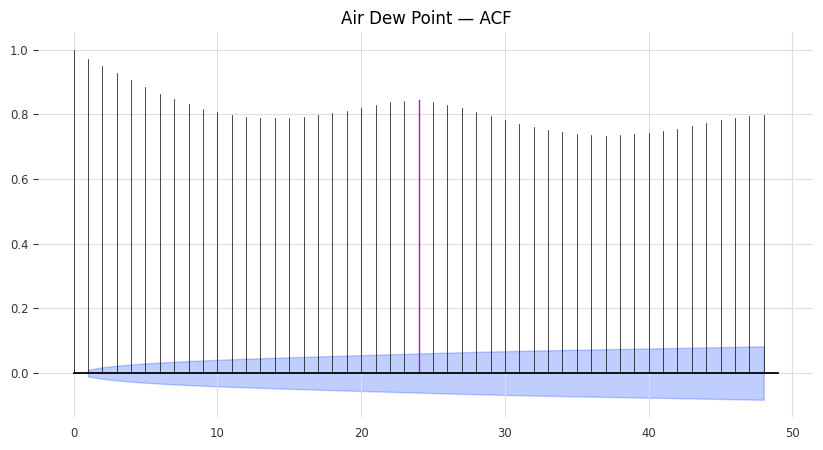

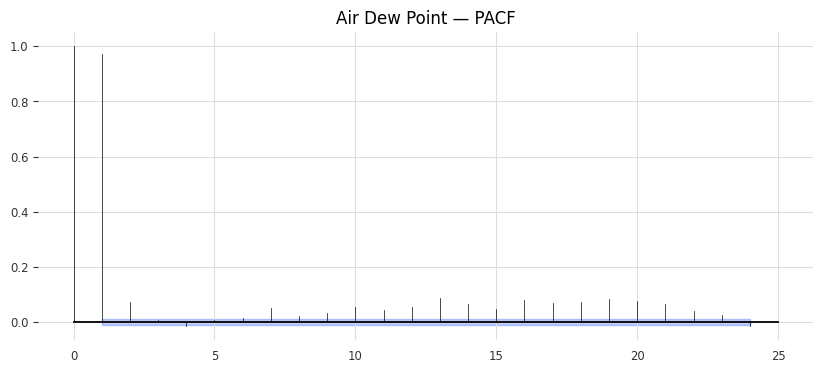

c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


The following tests were performed to determine the stationarity of: Air Dew Point
— ADF Test —
Statistic: -6.6412
p-value:   5.403e-09
Lags:      50, Observations: 34990
Critical values:
  1%: -3.4305
  5%: -2.8616
  10%: -2.5668

— KPSS Test —
Statistic: 0.7494
p-value:   0.01
Lags:      110
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Overall stationary? False ✅
***********************************************************************************




***********************************************************************************
===== Analyzing 'Air Temperature (OC)' 📈 =====


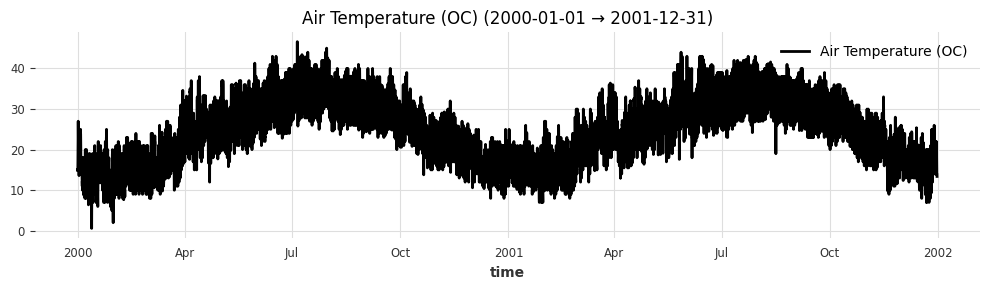

Seasonal? False, Period = 0


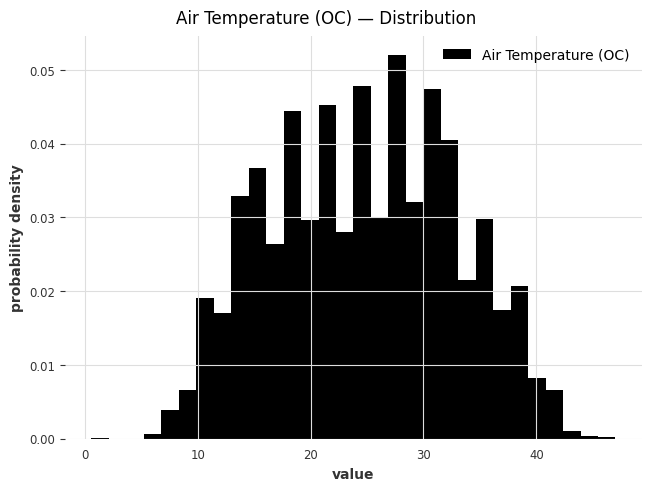

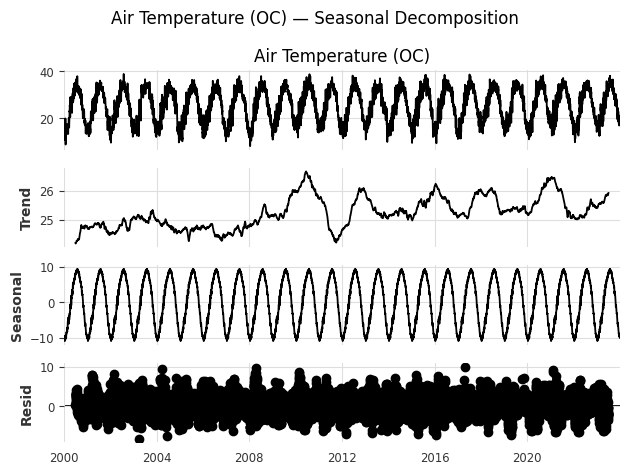

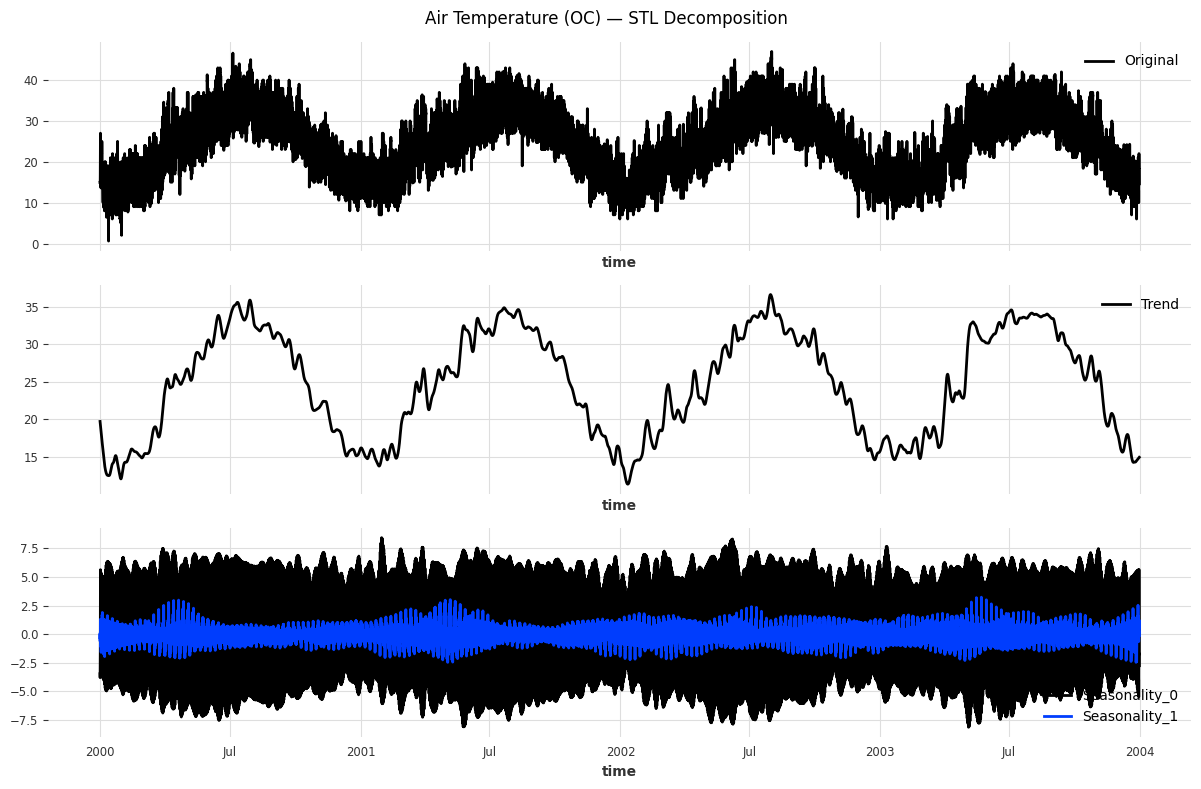


Causality tests: Air Dew Point → Air Temperature (OC)


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.9176 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=18.9192 , p=0.0000  , df=1
likelihood ratio test: chi2=18.9141 , p=0.0000  , df=1
parameter F test:         F=18.9176 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=42.5538 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=85.1198 , p=0.0000  , df=2
likelihood ratio test: chi2=85.0165 , p=0.0000  , df=2
parameter F test:         F=42.5538 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=106.2644, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=318.8568, p=0.0000  , df=3
likelihood ratio test: chi2=317.4147, p=0.0000  , df=3
parameter F test:         F=106.2644, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=213.1381

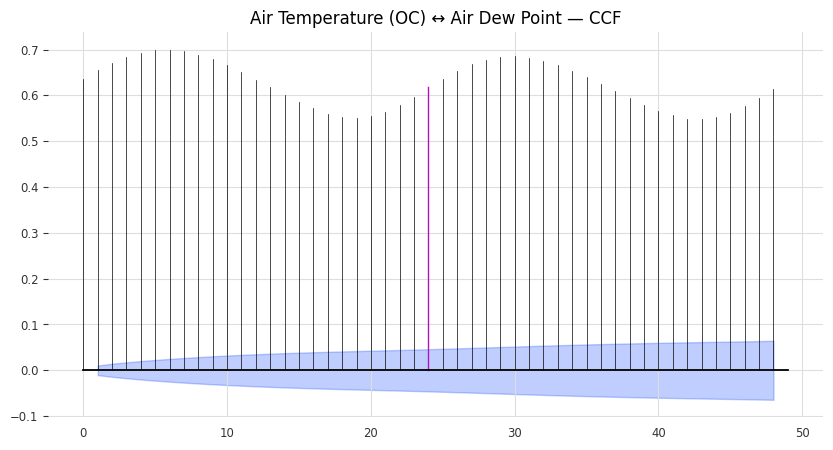


Causality tests: Humidity % → Air Temperature (OC)


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=540.2564, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=540.3027, p=0.0000  , df=1
likelihood ratio test: chi2=536.1794, p=0.0000  , df=1
parameter F test:         F=540.2564, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=818.2890, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=1636.8116, p=0.0000  , df=2
likelihood ratio test: chi2=1599.7310, p=0.0000  , df=2
parameter F test:         F=818.2890, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=732.3575, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=2197.5114, p=0.0000  , df=3
likelihood ratio test: chi2=2131.3520, p=0.0000  , df=3
parameter F test:         F=732.3575, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=609.

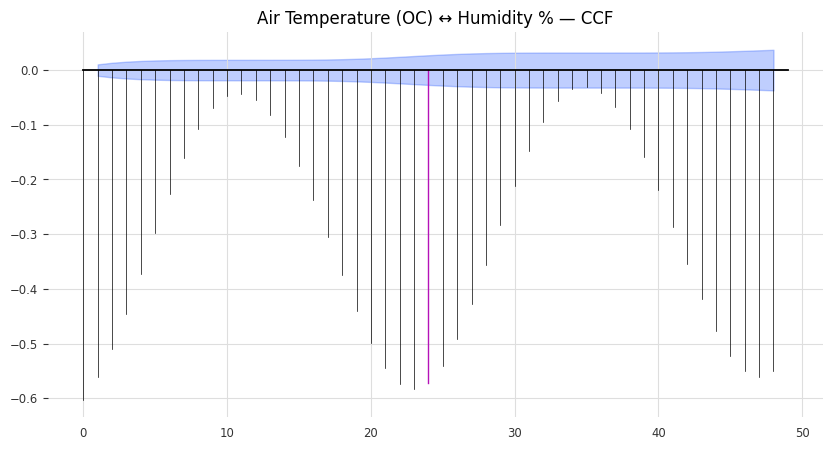


Causality tests: Atmospheric Pressure → Air Temperature (OC)


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2215.4336, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=2215.6232, p=0.0000  , df=1
likelihood ratio test: chi2=2148.3945, p=0.0000  , df=1
parameter F test:         F=2215.4336, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1283.4798, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=2567.3260, p=0.0000  , df=2
likelihood ratio test: chi2=2477.6271, p=0.0000  , df=2
parameter F test:         F=1283.4798, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1002.8583, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=3009.1760, p=0.0000  , df=3
likelihood ratio test: chi2=2886.9096, p=0.0000  , df=3
parameter F test:         F=1002.8583, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       

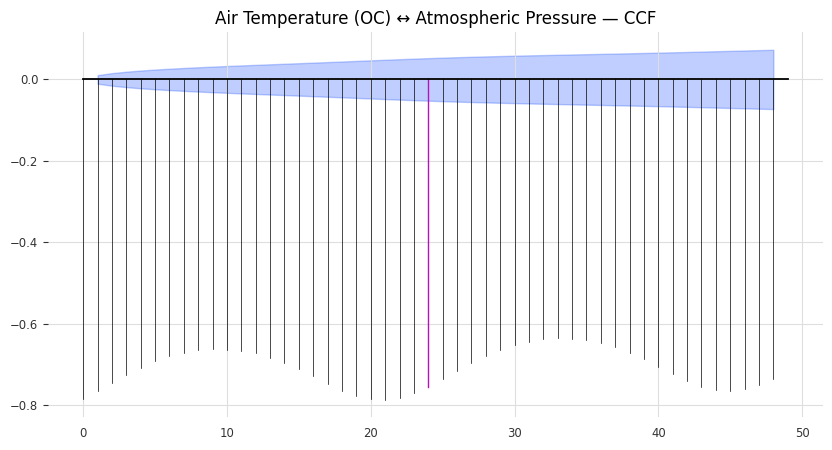


Causality tests: Wind_U → Air Temperature (OC)


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=123.2391, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=123.2497, p=0.0000  , df=1
likelihood ratio test: chi2=123.0334, p=0.0000  , df=1
parameter F test:         F=123.2391, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=66.5433 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=133.1055, p=0.0000  , df=2
likelihood ratio test: chi2=132.8534, p=0.0000  , df=2
parameter F test:         F=66.5433 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=56.5777 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=169.7669, p=0.0000  , df=3
likelihood ratio test: chi2=169.3570, p=0.0000  , df=3
parameter F test:         F=56.5777 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=49.9911 

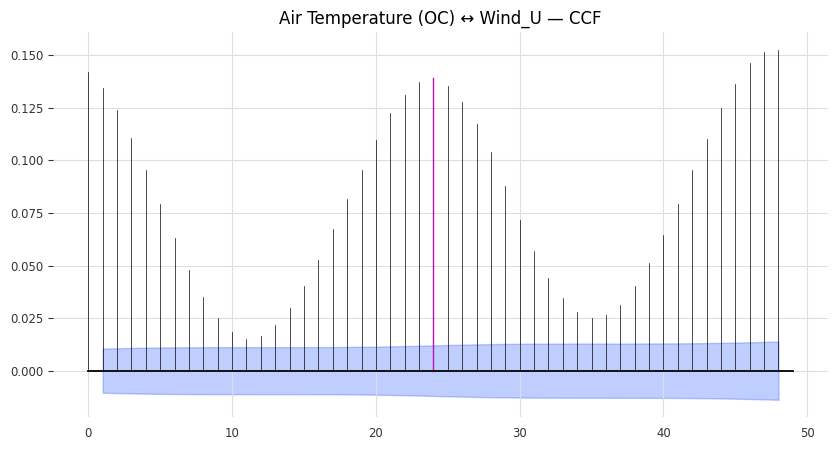


Causality tests: Wind_V → Air Temperature (OC)


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=52.0409 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=52.0454 , p=0.0000  , df=1
likelihood ratio test: chi2=52.0067 , p=0.0000  , df=1
parameter F test:         F=52.0409 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=150.6858, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=301.4146, p=0.0000  , df=2
likelihood ratio test: chi2=300.1255, p=0.0000  , df=2
parameter F test:         F=150.6858, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=113.7760, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=341.3963, p=0.0000  , df=3
likelihood ratio test: chi2=339.7439, p=0.0000  , df=3
parameter F test:         F=113.7760, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=90.7629 

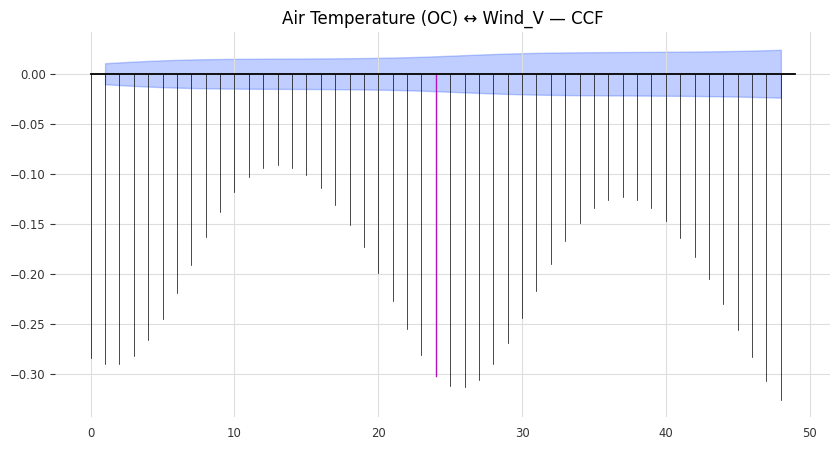

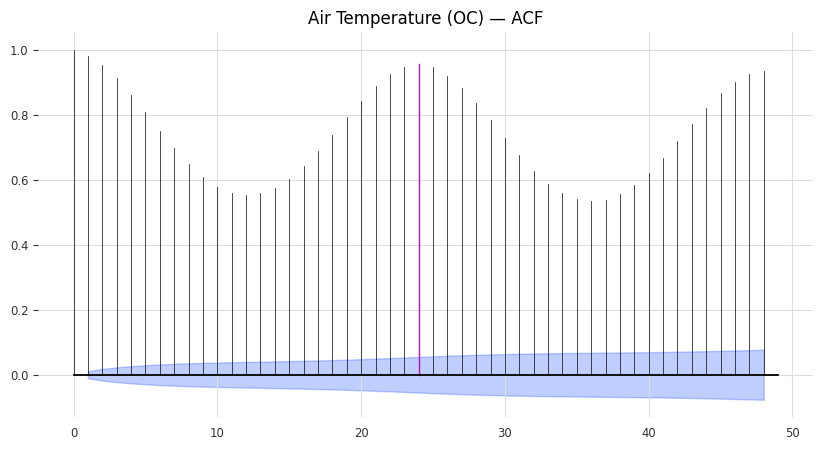

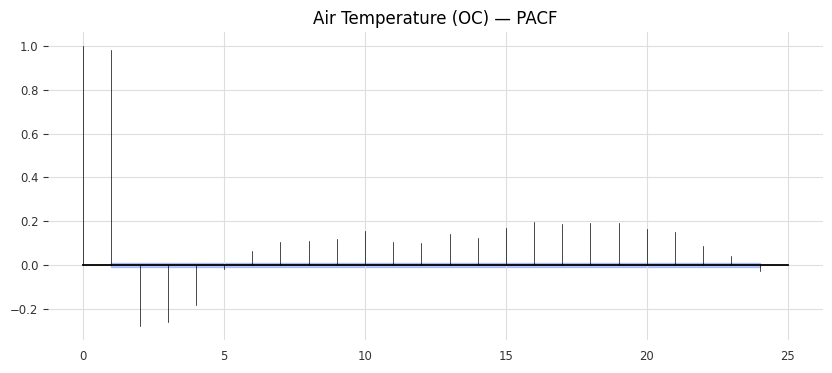

c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


The following tests were performed to determine the stationarity of: Air Temperature (OC)
— ADF Test —
Statistic: -4.3890
p-value:   0.0003104
Lags:      52, Observations: 34988
Critical values:
  1%: -3.4305
  5%: -2.8616
  10%: -2.5668

— KPSS Test —
Statistic: 0.7882
p-value:   0.01
Lags:      104
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Overall stationary? False ✅
***********************************************************************************




***********************************************************************************
===== Analyzing 'Humidity %' 📈 =====


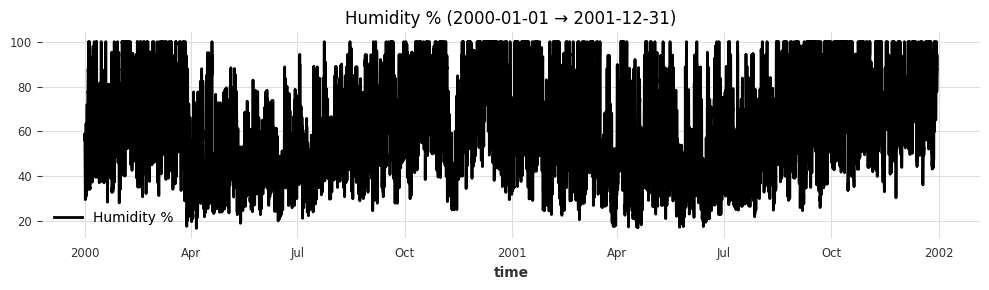

Seasonal? False, Period = 0


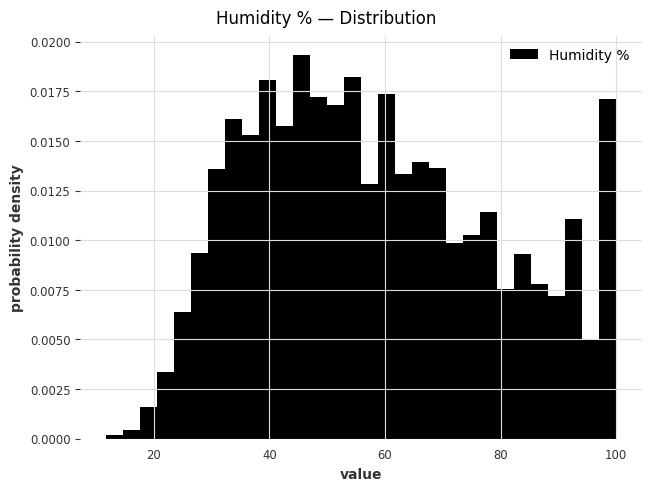

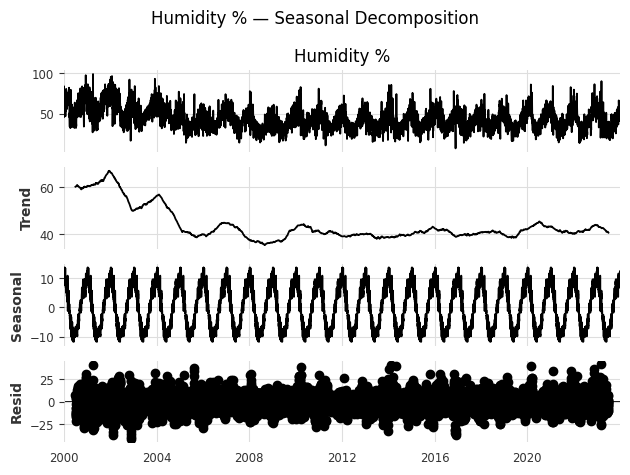

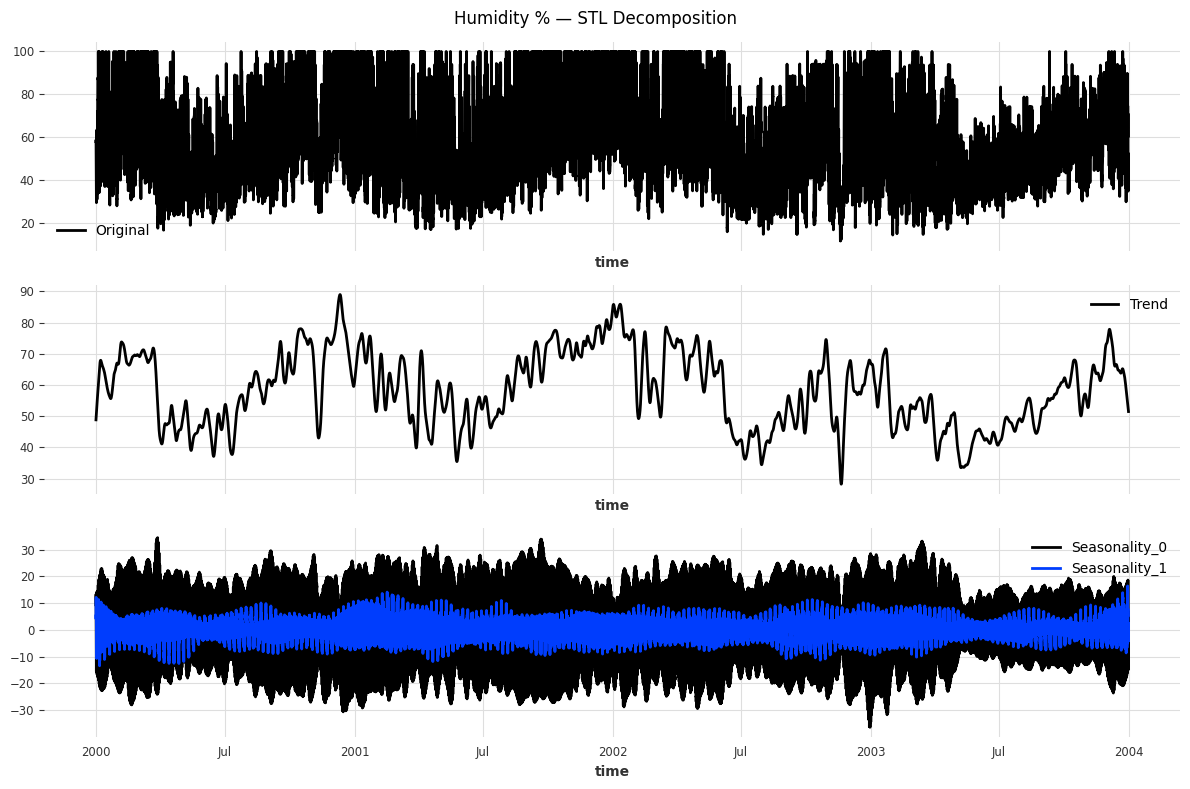


Causality tests: Air Dew Point → Humidity %


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.2663 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=18.2678 , p=0.0000  , df=1
likelihood ratio test: chi2=18.2631 , p=0.0000  , df=1
parameter F test:         F=18.2663 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=35.8705 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=71.7512 , p=0.0000  , df=2
likelihood ratio test: chi2=71.6779 , p=0.0000  , df=2
parameter F test:         F=35.8705 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=100.4070, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=301.2811, p=0.0000  , df=3
likelihood ratio test: chi2=299.9932, p=0.0000  , df=3
parameter F test:         F=100.4070, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=214.2581

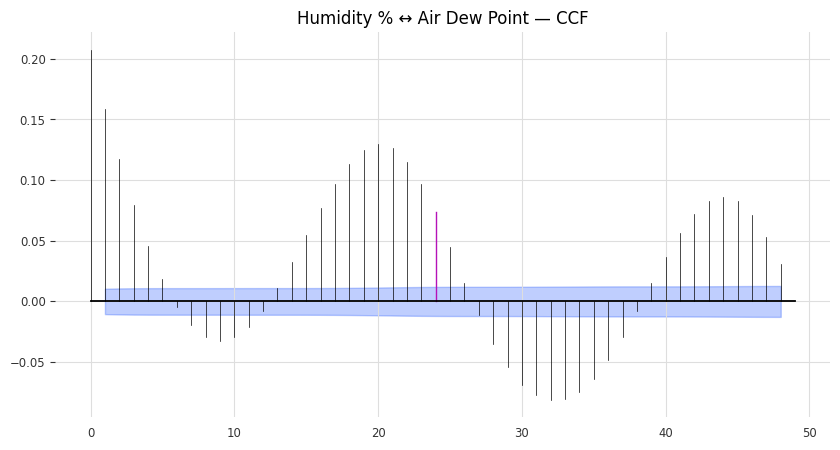


Causality tests: Air Temperature (OC) → Humidity %


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1322.5412, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=1322.6544, p=0.0000  , df=1
likelihood ratio test: chi2=1298.3022, p=0.0000  , df=1
parameter F test:         F=1322.5412, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=641.9827, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=1284.1486, p=0.0000  , df=2
likelihood ratio test: chi2=1261.1767, p=0.0000  , df=2
parameter F test:         F=641.9827, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=463.8556, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=1391.8449, p=0.0000  , df=3
likelihood ratio test: chi2=1364.9111, p=0.0000  , df=3
parameter F test:         F=463.8556, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=

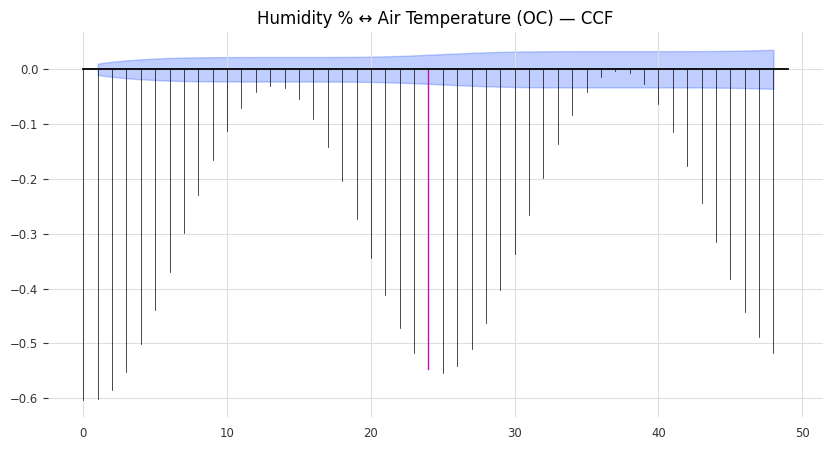


Causality tests: Atmospheric Pressure → Humidity %


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=491.4830, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=491.5251, p=0.0000  , df=1
likelihood ratio test: chi2=488.1095, p=0.0000  , df=1
parameter F test:         F=491.4830, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=500.9424, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=1002.0277, p=0.0000  , df=2
likelihood ratio test: chi2=987.9674, p=0.0000  , df=2
parameter F test:         F=500.9424, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=492.9925, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=1479.2731, p=0.0000  , df=3
likelihood ratio test: chi2=1448.8983, p=0.0000  , df=3
parameter F test:         F=492.9925, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=544.1

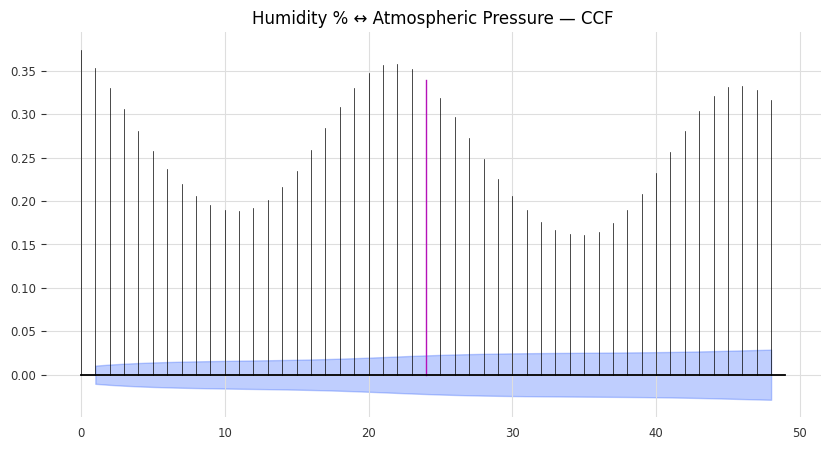


Causality tests: Wind_U → Humidity %


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.2873 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=29.2898 , p=0.0000  , df=1
likelihood ratio test: chi2=29.2775 , p=0.0000  , df=1
parameter F test:         F=29.2873 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=23.1327 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=46.2720 , p=0.0000  , df=2
likelihood ratio test: chi2=46.2414 , p=0.0000  , df=2
parameter F test:         F=23.1327 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.3300 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=88.0076 , p=0.0000  , df=3
likelihood ratio test: chi2=87.8973 , p=0.0000  , df=3
parameter F test:         F=29.3300 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=27.1766 

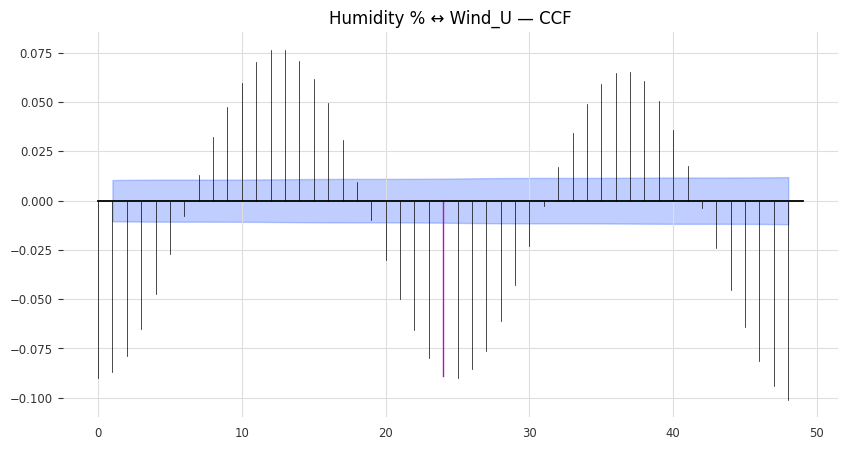


Causality tests: Wind_V → Humidity %


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=75.3426 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=75.3491 , p=0.0000  , df=1
likelihood ratio test: chi2=75.2682 , p=0.0000  , df=1
parameter F test:         F=75.3426 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=126.0455, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=252.1270, p=0.0000  , df=2
likelihood ratio test: chi2=251.2242, p=0.0000  , df=2
parameter F test:         F=126.0455, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=106.6960, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=320.1519, p=0.0000  , df=3
likelihood ratio test: chi2=318.6981, p=0.0000  , df=3
parameter F test:         F=106.6960, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=89.8069 

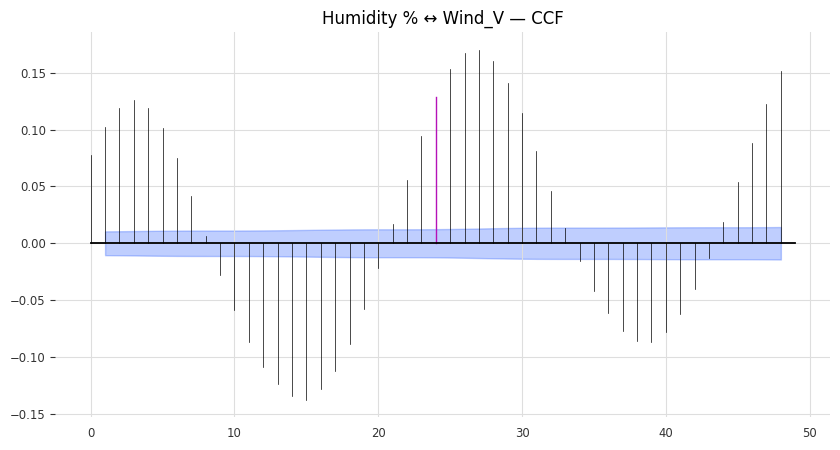

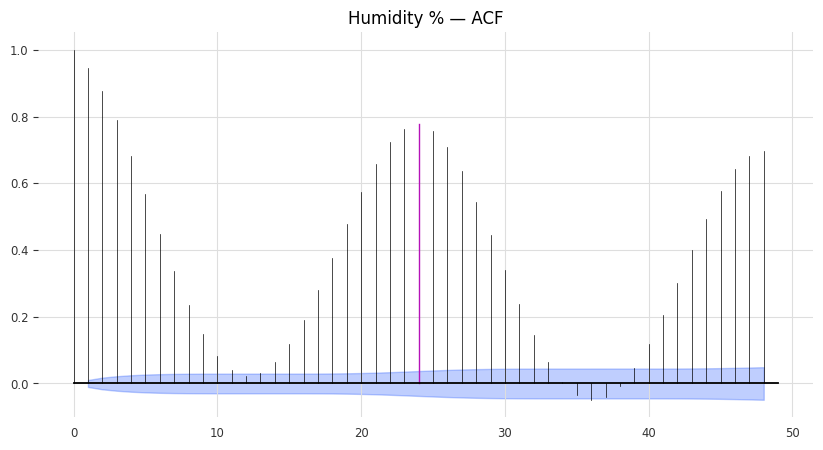

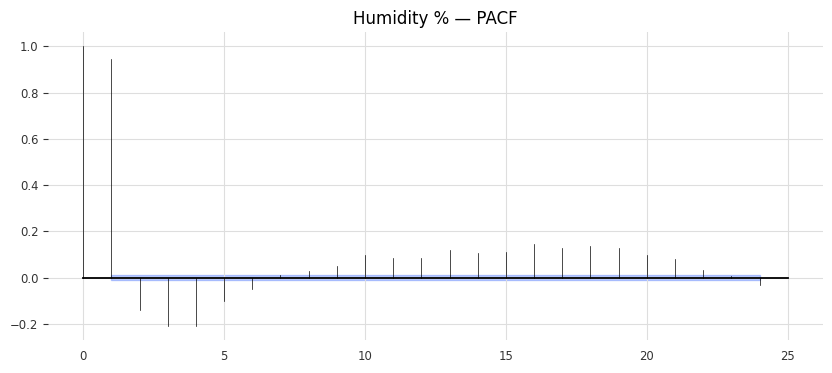

c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


The following tests were performed to determine the stationarity of: Humidity %
— ADF Test —
Statistic: -11.8834
p-value:   6.103e-22
Lags:      52, Observations: 34988
Critical values:
  1%: -3.4305
  5%: -2.8616
  10%: -2.5668

— KPSS Test —
Statistic: 2.6619
p-value:   0.01
Lags:      86
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Overall stationary? False ✅
***********************************************************************************




***********************************************************************************
===== Analyzing 'Atmospheric Pressure' 📈 =====


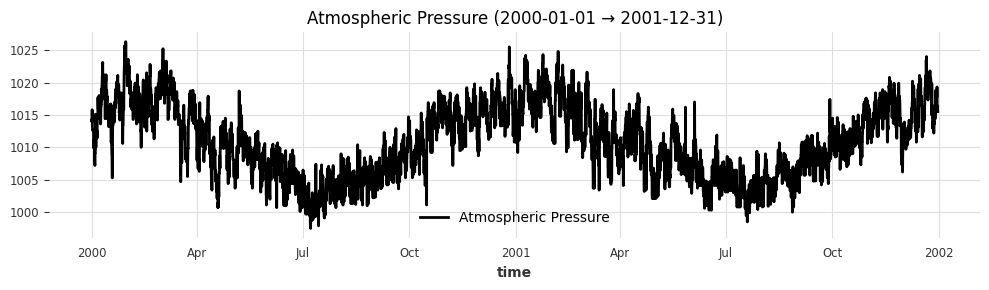

Seasonal? False, Period = 0


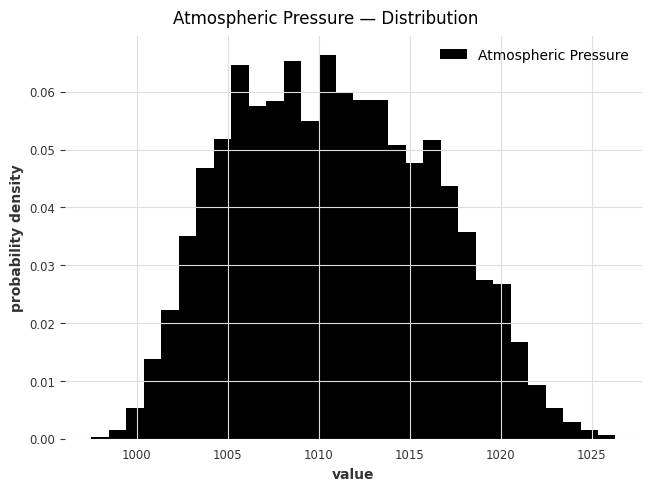

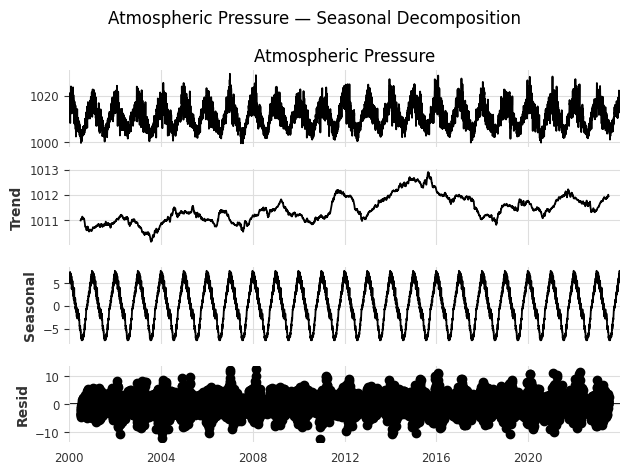

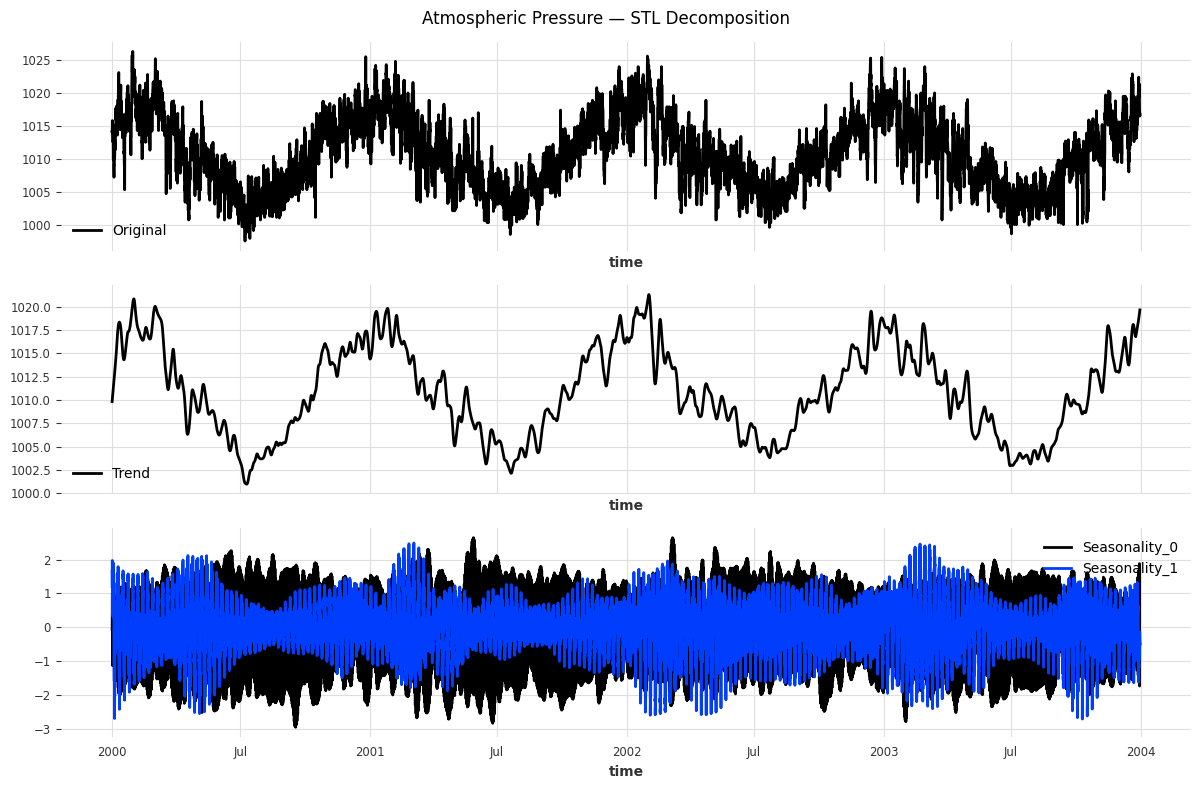


Causality tests: Air Dew Point → Atmospheric Pressure


ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=223.8635, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=223.8827, p=0.0000  , df=1
likelihood ratio test: chi2=223.1705, p=0.0000  , df=1
parameter F test:         F=223.8635, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=149.2241, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=298.4908, p=0.0000  , df=2
likelihood ratio test: chi2=297.2266, p=0.0000  , df=2
parameter F test:         F=149.2241, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=148.1513, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=444.5426, p=0.0000  , df=3
likelihood ratio test: chi2=441.7462, p=0.0000  , df=3
parameter F test:         F=148.1513, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=184.5970

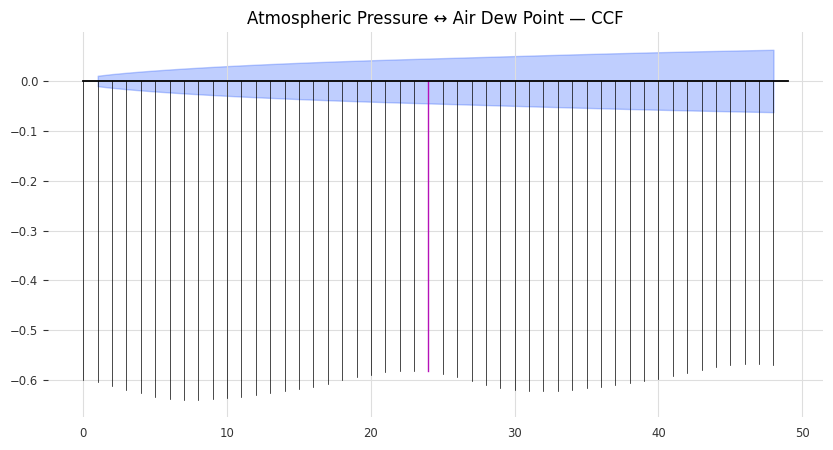


Causality tests: Air Temperature (OC) → Atmospheric Pressure


ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=54.3166 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=54.3213 , p=0.0000  , df=1
likelihood ratio test: chi2=54.2792 , p=0.0000  , df=1
parameter F test:         F=54.3166 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=35.2248 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=70.4597 , p=0.0000  , df=2
likelihood ratio test: chi2=70.3890 , p=0.0000  , df=2
parameter F test:         F=35.2248 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=180.5107, p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=541.6404, p=0.0000  , df=3
likelihood ratio test: chi2=537.4965, p=0.0000  , df=3
parameter F test:         F=180.5107, p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=330.8656

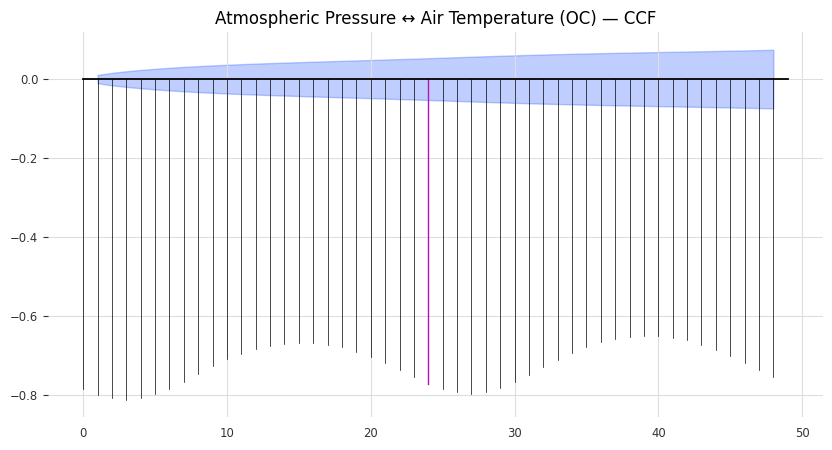


Causality tests: Humidity % → Atmospheric Pressure


ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2031  , p=0.6523  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=0.2031  , p=0.6523  , df=1
likelihood ratio test: chi2=0.2031  , p=0.6523  , df=1
parameter F test:         F=0.2031  , p=0.6523  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.4136 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=30.8316 , p=0.0000  , df=2
likelihood ratio test: chi2=30.8181 , p=0.0000  , df=2
parameter F test:         F=15.4136 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.6968 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=47.0999 , p=0.0000  , df=3
likelihood ratio test: chi2=47.0683 , p=0.0000  , df=3
parameter F test:         F=15.6968 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=32.0655 

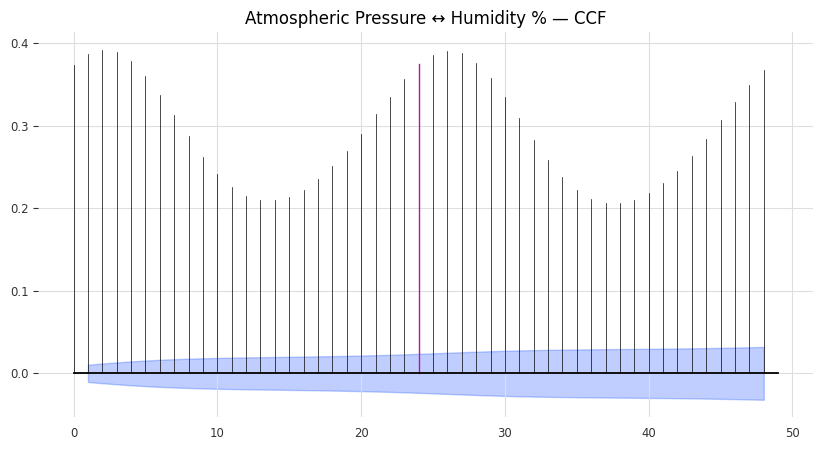


Causality tests: Wind_U → Atmospheric Pressure


ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=92.6311 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=92.6390 , p=0.0000  , df=1
likelihood ratio test: chi2=92.5167 , p=0.0000  , df=1
parameter F test:         F=92.6311 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=32.6546 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=65.3185 , p=0.0000  , df=2
likelihood ratio test: chi2=65.2577 , p=0.0000  , df=2
parameter F test:         F=32.6546 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=19.4984 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=58.5068 , p=0.0000  , df=3
likelihood ratio test: chi2=58.4580 , p=0.0000  , df=3
parameter F test:         F=19.4984 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=14.1155 

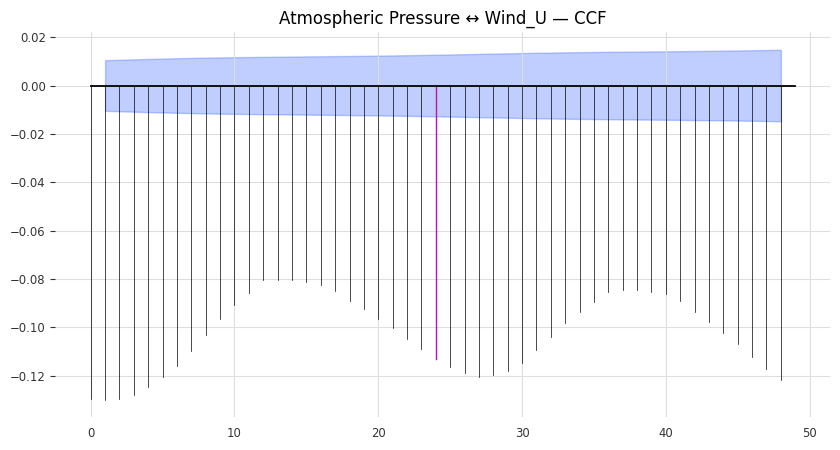


Causality tests: Wind_V → Atmospheric Pressure


ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5757  , p=0.2094  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=1.5758  , p=0.2094  , df=1
likelihood ratio test: chi2=1.5758  , p=0.2094  , df=1
parameter F test:         F=1.5757  , p=0.2094  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9052  , p=0.4045  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=1.8106  , p=0.4044  , df=2
likelihood ratio test: chi2=1.8106  , p=0.4044  , df=2
parameter F test:         F=0.9052  , p=0.4045  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7455  , p=0.0006  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=17.2401 , p=0.0006  , df=3
likelihood ratio test: chi2=17.2358 , p=0.0006  , df=3
parameter F test:         F=5.7455  , p=0.0006  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.4160  

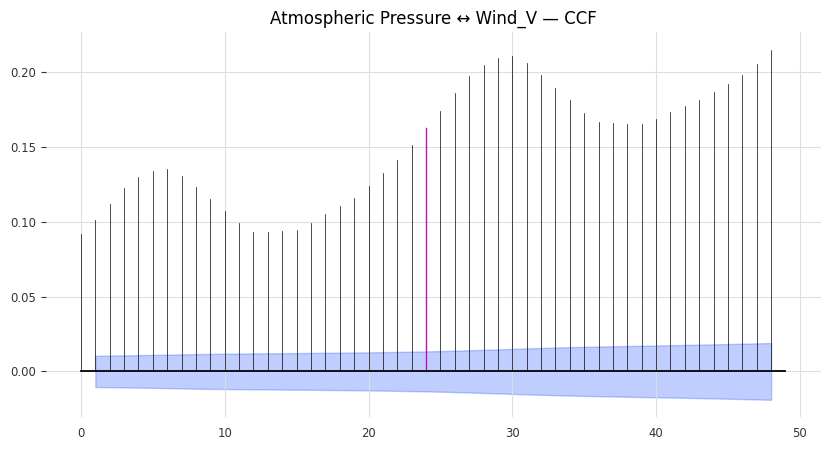

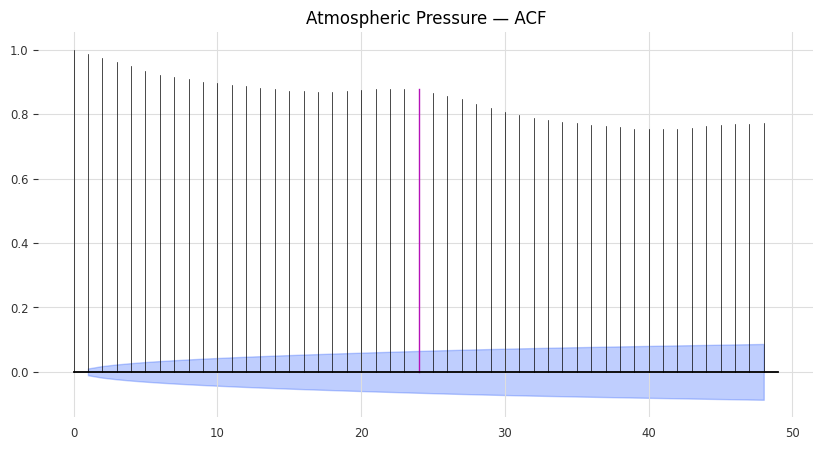

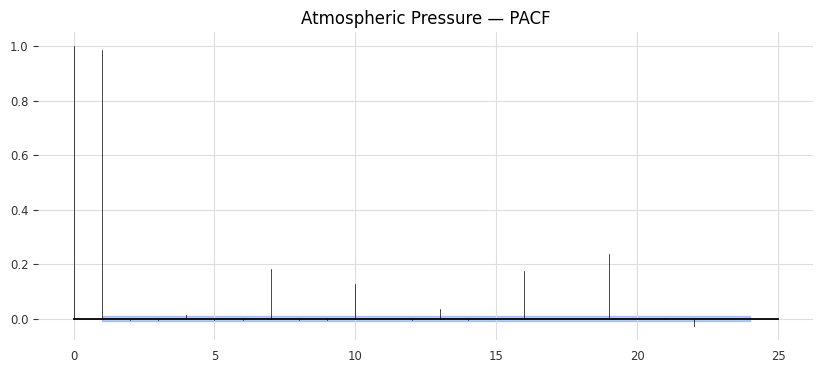

The following tests were performed to determine the stationarity of: Atmospheric Pressure
— ADF Test —
Statistic: -8.7123
p-value:   3.563e-14
Lags:      51, Observations: 34989
Critical values:
  1%: -3.4305
  5%: -2.8616
  10%: -2.5668

— KPSS Test —
Statistic: 0.5433
p-value:   0.03192
Lags:      111
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Overall stationary? False ✅
***********************************************************************************




***********************************************************************************
===== Analyzing 'Wind_U' 📈 =====


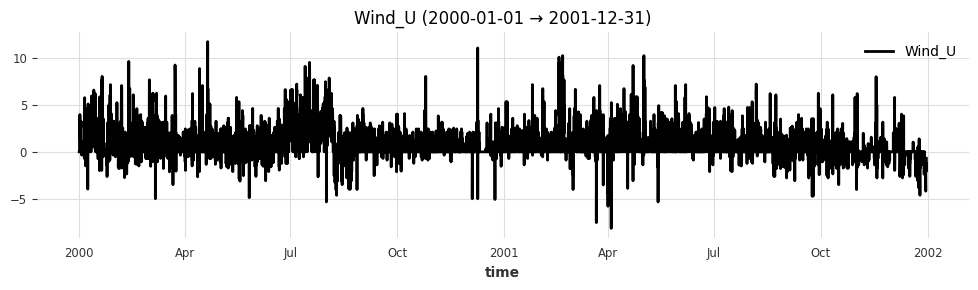

Seasonal? False, Period = 0


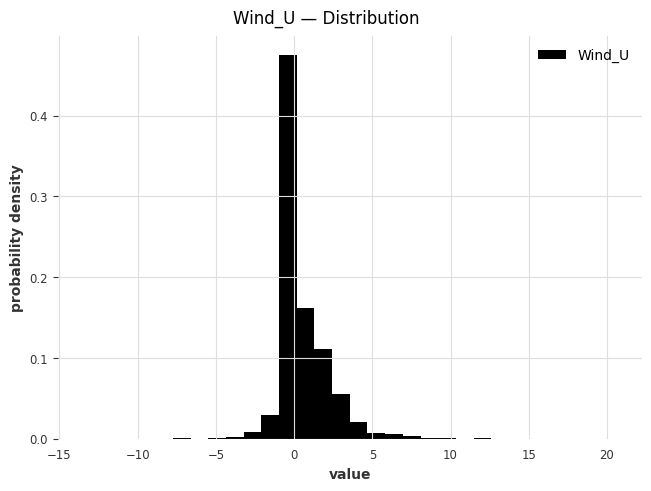

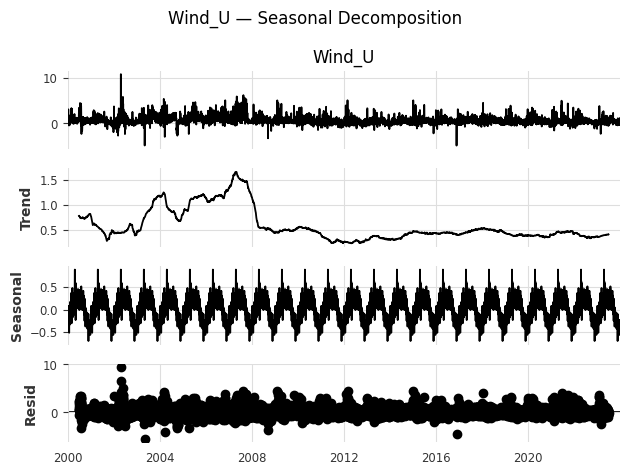

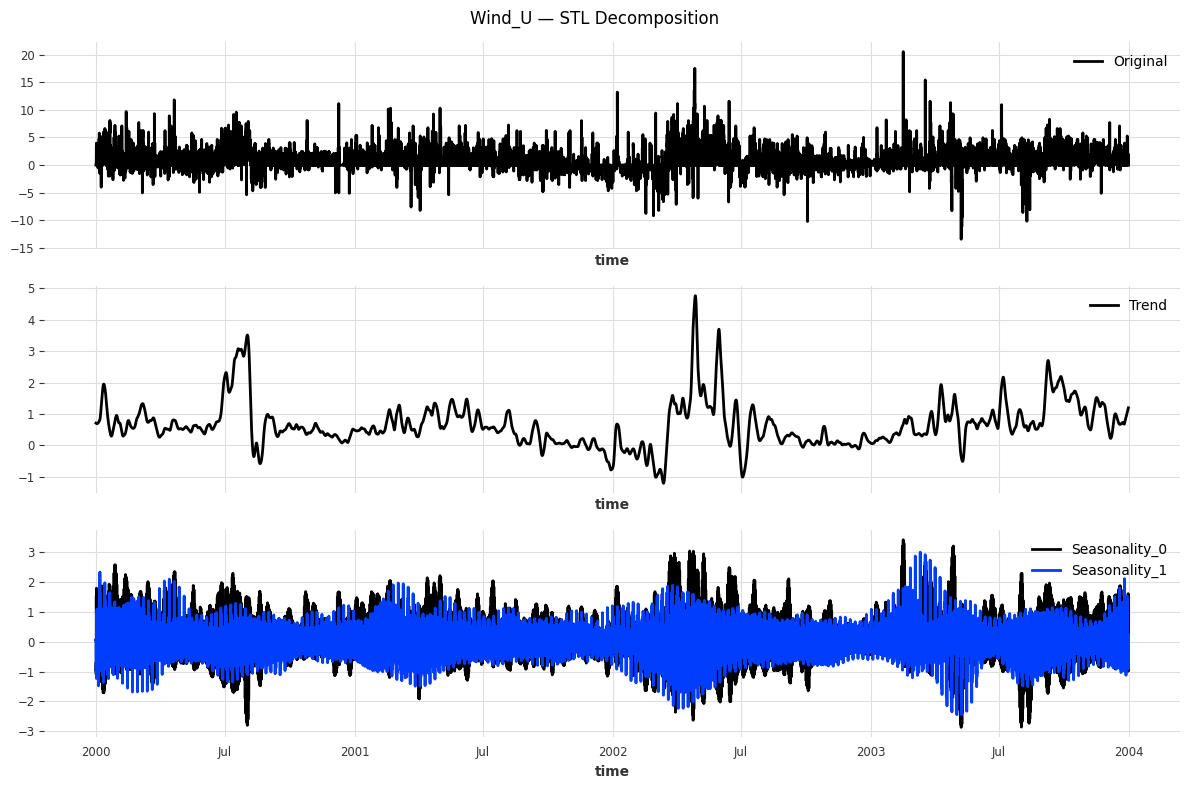


Causality tests: Air Dew Point → Wind_U


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9943  , p=0.0457  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=3.9947  , p=0.0456  , df=1
likelihood ratio test: chi2=3.9944  , p=0.0457  , df=1
parameter F test:         F=3.9943  , p=0.0457  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6581  , p=0.0258  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=7.3172  , p=0.0258  , df=2
likelihood ratio test: chi2=7.3164  , p=0.0258  , df=2
parameter F test:         F=3.6581  , p=0.0258  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9625  , p=0.0308  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=8.8892  , p=0.0308  , df=3
likelihood ratio test: chi2=8.8880  , p=0.0308  , df=3
parameter F test:         F=2.9625  , p=0.0308  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7968  

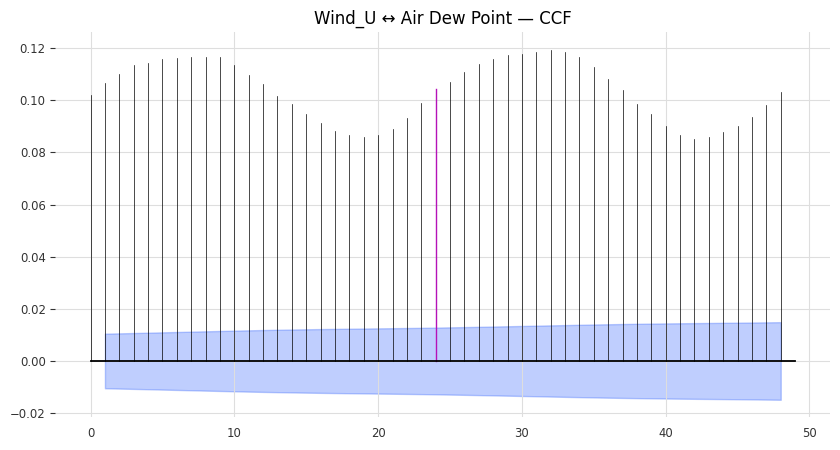


Causality tests: Air Temperature (OC) → Wind_U


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.2455 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=21.2473 , p=0.0000  , df=1
likelihood ratio test: chi2=21.2409 , p=0.0000  , df=1
parameter F test:         F=21.2455 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.2562 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=30.5168 , p=0.0000  , df=2
likelihood ratio test: chi2=30.5036 , p=0.0000  , df=2
parameter F test:         F=15.2562 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.3199 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=33.9665 , p=0.0000  , df=3
likelihood ratio test: chi2=33.9501 , p=0.0000  , df=3
parameter F test:         F=11.3199 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.3517 

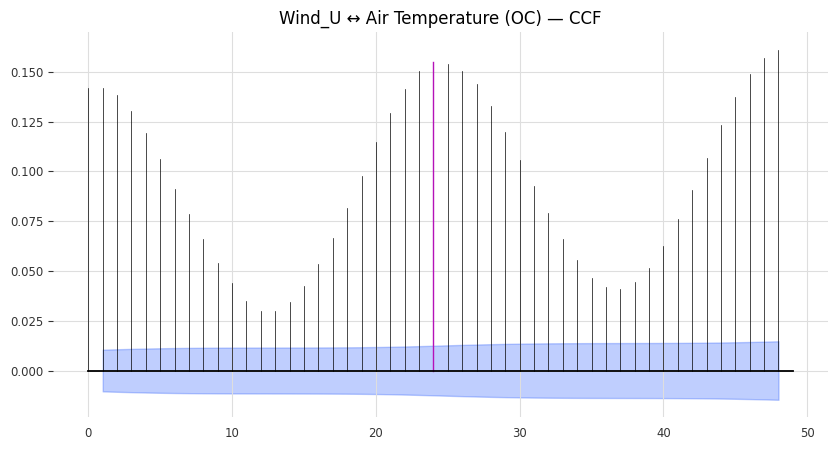


Causality tests: Humidity % → Wind_U


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4867  , p=0.2227  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=1.4869  , p=0.2227  , df=1
likelihood ratio test: chi2=1.4868  , p=0.2227  , df=1
parameter F test:         F=1.4867  , p=0.2227  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2172  , p=0.0054  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=10.4359 , p=0.0054  , df=2
likelihood ratio test: chi2=10.4343 , p=0.0054  , df=2
parameter F test:         F=5.2172  , p=0.0054  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.8196  , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=26.4641 , p=0.0000  , df=3
likelihood ratio test: chi2=26.4541 , p=0.0000  , df=3
parameter F test:         F=8.8196  , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.3912  

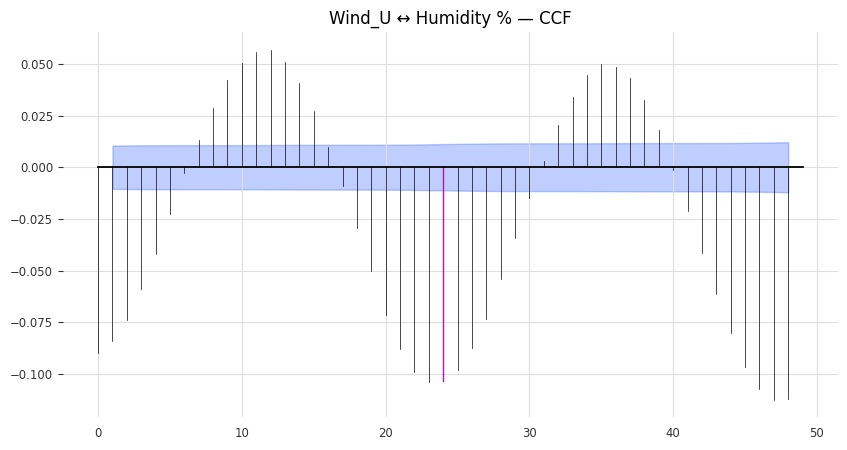


Causality tests: Atmospheric Pressure → Wind_U


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2390  , p=0.0221  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=5.2394  , p=0.0221  , df=1
likelihood ratio test: chi2=5.2390  , p=0.0221  , df=1
parameter F test:         F=5.2390  , p=0.0221  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6212  , p=0.0727  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=5.2432  , p=0.0727  , df=2
likelihood ratio test: chi2=5.2428  , p=0.0727  , df=2
parameter F test:         F=2.6212  , p=0.0727  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7522  , p=0.0410  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=8.2583  , p=0.0410  , df=3
likelihood ratio test: chi2=8.2573  , p=0.0410  , df=3
parameter F test:         F=2.7522  , p=0.0410  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8750  

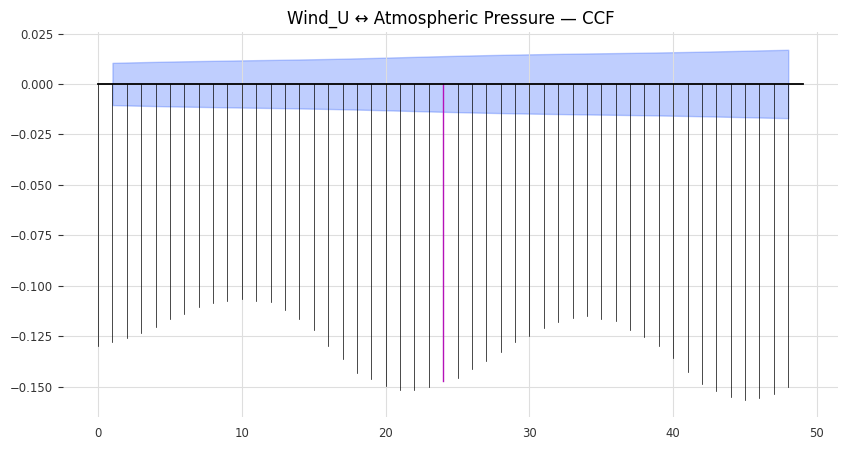


Causality tests: Wind_V → Wind_U


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.0886 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=19.0902 , p=0.0000  , df=1
likelihood ratio test: chi2=19.0850 , p=0.0000  , df=1
parameter F test:         F=19.0886 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.0616 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=42.1292 , p=0.0000  , df=2
likelihood ratio test: chi2=42.1039 , p=0.0000  , df=2
parameter F test:         F=21.0616 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.8487 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=44.5551 , p=0.0000  , df=3
likelihood ratio test: chi2=44.5268 , p=0.0000  , df=3
parameter F test:         F=14.8487 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.3845 

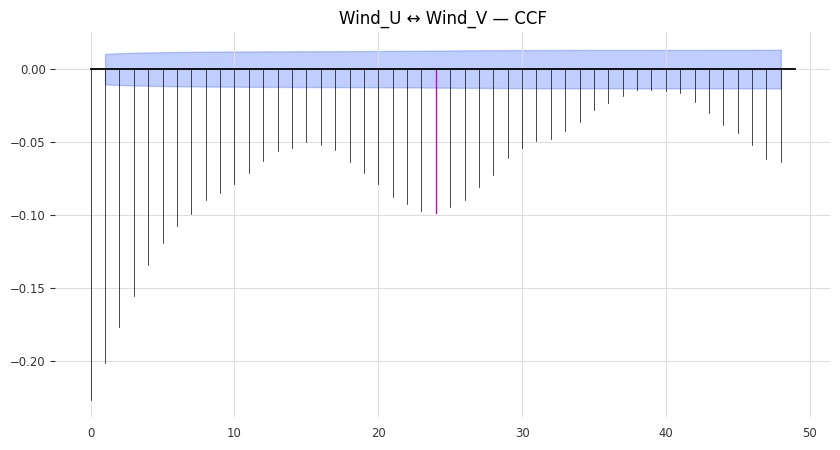

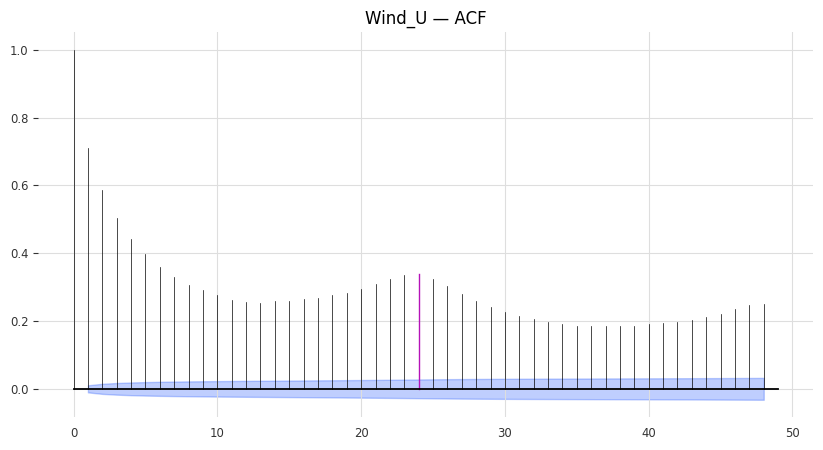

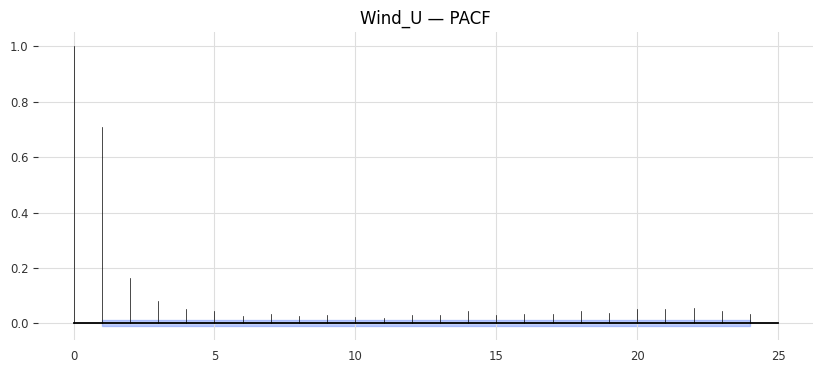

c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


The following tests were performed to determine the stationarity of: Wind_U
— ADF Test —
Statistic: -14.0913
p-value:   2.719e-26
Lags:      48, Observations: 34992
Critical values:
  1%: -3.4305
  5%: -2.8616
  10%: -2.5668

— KPSS Test —
Statistic: 0.8457
p-value:   0.01
Lags:      96
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Overall stationary? False ✅
***********************************************************************************




***********************************************************************************
===== Analyzing 'Wind_V' 📈 =====


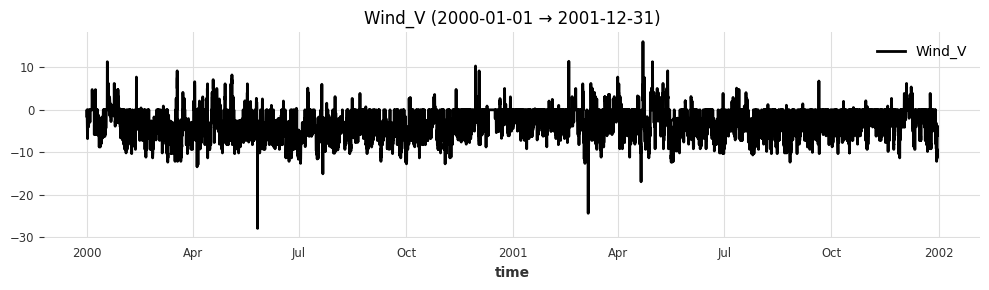

Seasonal? False, Period = 0


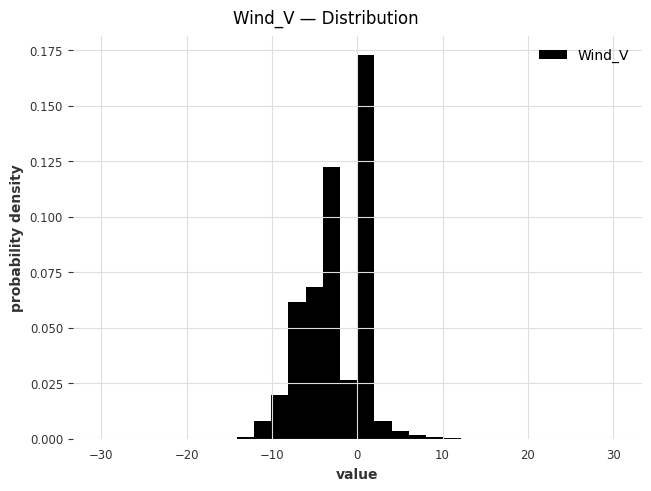

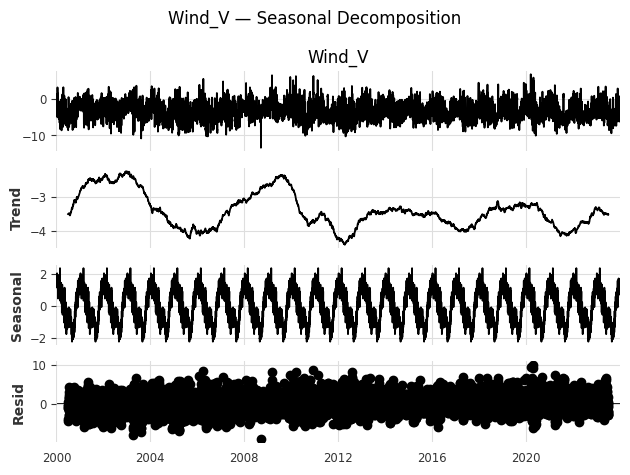

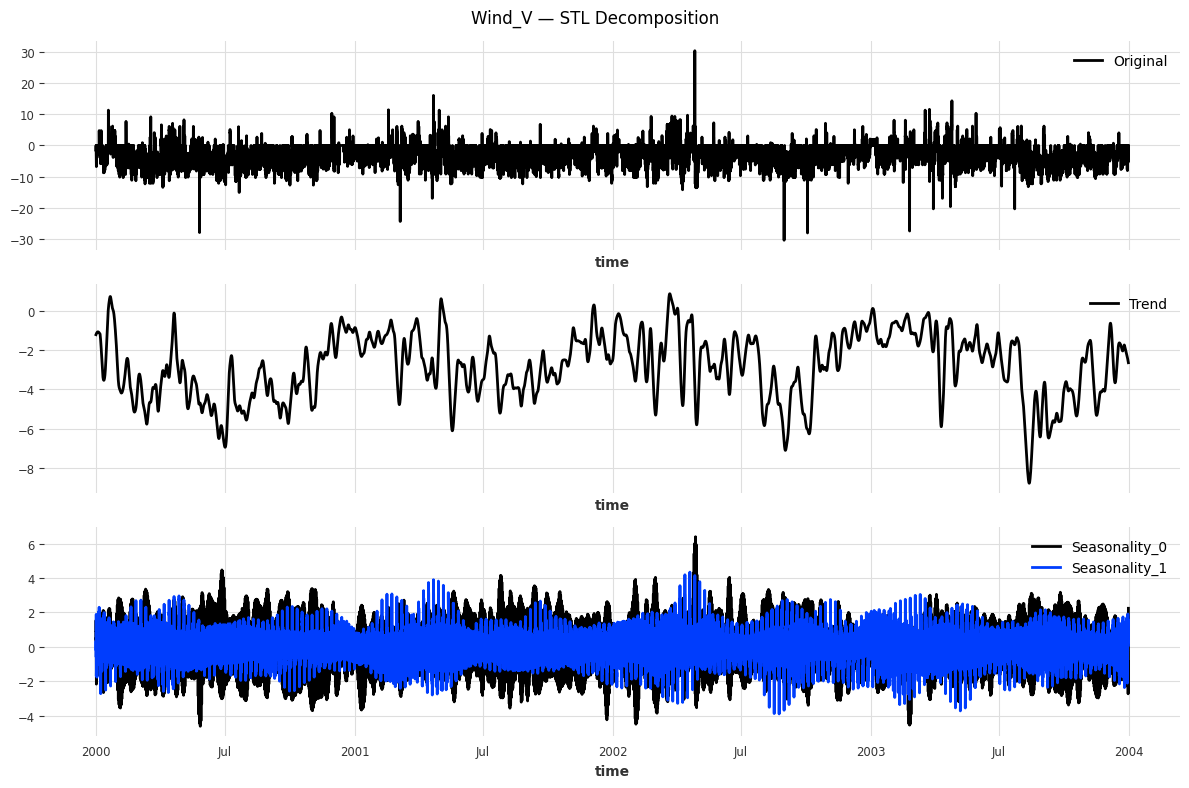


Causality tests: Air Dew Point → Wind_V


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.2074 , p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=38.2107 , p=0.0000  , df=1
likelihood ratio test: chi2=38.1899 , p=0.0000  , df=1
parameter F test:         F=38.2074 , p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=70.1895 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=140.3991, p=0.0000  , df=2
likelihood ratio test: chi2=140.1186, p=0.0000  , df=2
parameter F test:         F=70.1895 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=58.5430 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=175.6640, p=0.0000  , df=3
likelihood ratio test: chi2=175.2251, p=0.0000  , df=3
parameter F test:         F=58.5430 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=43.7648 

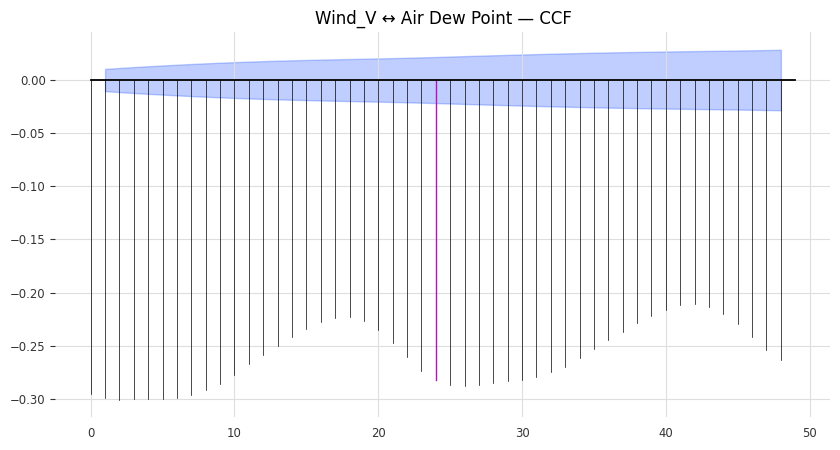


Causality tests: Air Temperature (OC) → Wind_V


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=145.5091, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=145.5216, p=0.0000  , df=1
likelihood ratio test: chi2=145.2202, p=0.0000  , df=1
parameter F test:         F=145.5091, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=38.1188 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=76.2485 , p=0.0000  , df=2
likelihood ratio test: chi2=76.1656 , p=0.0000  , df=2
parameter F test:         F=38.1188 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=19.3882 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=58.1762 , p=0.0000  , df=3
likelihood ratio test: chi2=58.1279 , p=0.0000  , df=3
parameter F test:         F=19.3882 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=31.3451 

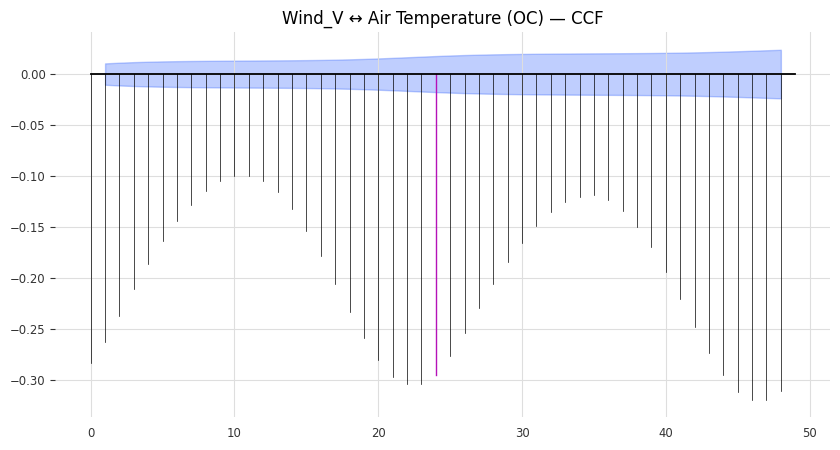


Causality tests: Humidity % → Wind_V


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=271.2819, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=271.3052, p=0.0000  , df=1
likelihood ratio test: chi2=270.2602, p=0.0000  , df=1
parameter F test:         F=271.2819, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=101.8291, p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=203.6874, p=0.0000  , df=2
likelihood ratio test: chi2=203.0976, p=0.0000  , df=2
parameter F test:         F=101.8291, p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=48.2023 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=144.6357, p=0.0000  , df=3
likelihood ratio test: chi2=144.3380, p=0.0000  , df=3
parameter F test:         F=48.2023 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=51.2772 

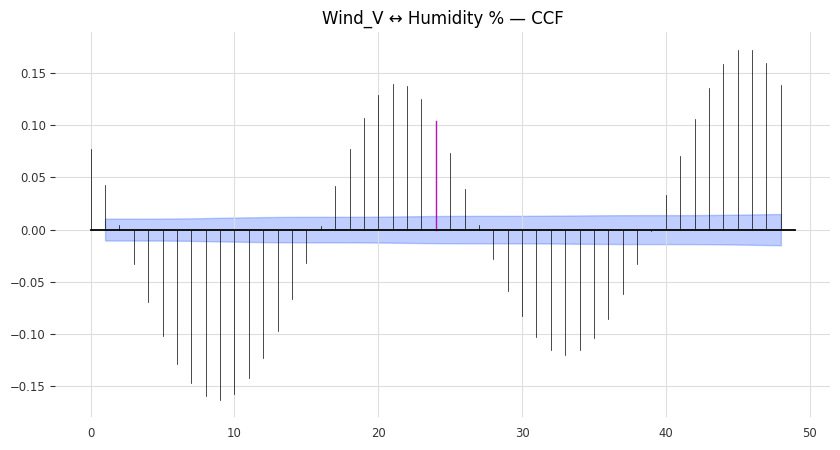


Causality tests: Atmospheric Pressure → Wind_V


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=162.2437, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=162.2576, p=0.0000  , df=1
likelihood ratio test: chi2=161.8831, p=0.0000  , df=1
parameter F test:         F=162.2437, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=94.9072 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=189.8415, p=0.0000  , df=2
likelihood ratio test: chi2=189.3291, p=0.0000  , df=2
parameter F test:         F=94.9072 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=74.5851 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=223.8000, p=0.0000  , df=3
likelihood ratio test: chi2=223.0883, p=0.0000  , df=3
parameter F test:         F=74.5851 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=63.2388 

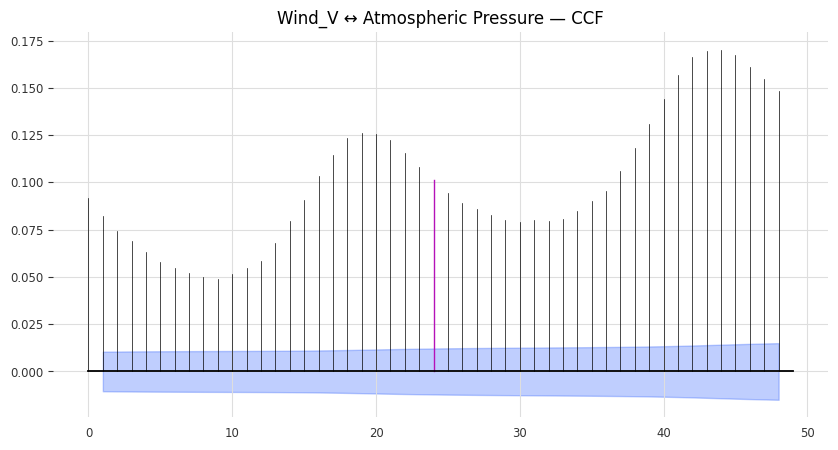


Causality tests: Wind_U → Wind_V


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.
c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_effect doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=121.7929, p=0.0000  , df_denom=35037, df_num=1
ssr based chi2 test:   chi2=121.8033, p=0.0000  , df=1
likelihood ratio test: chi2=121.5921, p=0.0000  , df=1
parameter F test:         F=121.7929, p=0.0000  , df_denom=35037, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=50.3601 , p=0.0000  , df_denom=35034, df_num=2
ssr based chi2 test:   chi2=100.7345, p=0.0000  , df=2
likelihood ratio test: chi2=100.5900, p=0.0000  , df=2
parameter F test:         F=50.3601 , p=0.0000  , df_denom=35034, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=36.6565 , p=0.0000  , df_denom=35031, df_num=3
ssr based chi2 test:   chi2=109.9916, p=0.0000  , df=3
likelihood ratio test: chi2=109.8193, p=0.0000  , df=3
parameter F test:         F=36.6565 , p=0.0000  , df_denom=35031, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=31.0758 

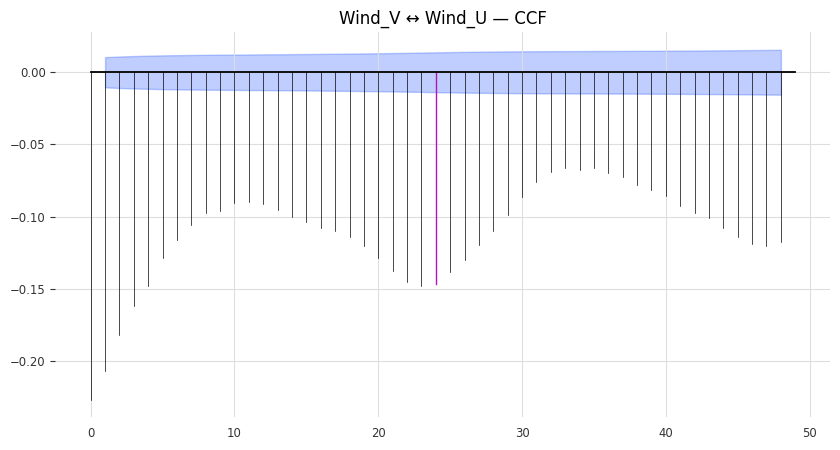

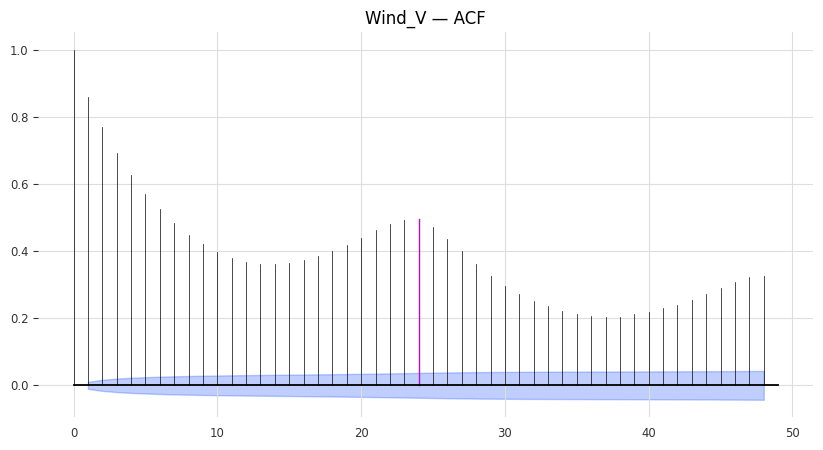

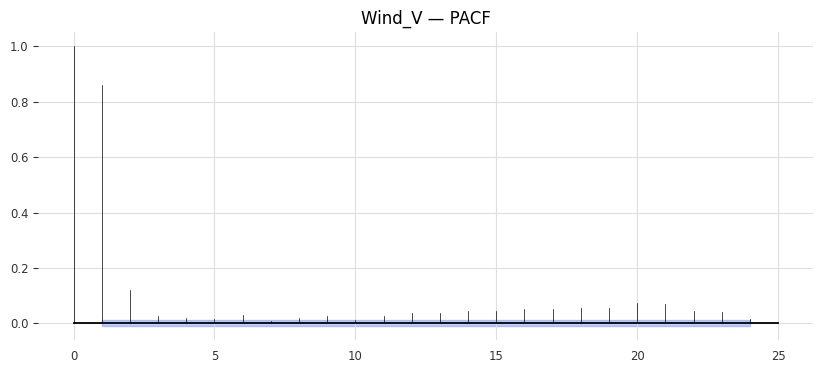

c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


The following tests were performed to determine the stationarity of: Wind_V
— ADF Test —
Statistic: -15.8402
p-value:   9.714e-29
Lags:      51, Observations: 34989
Critical values:
  1%: -3.4305
  5%: -2.8616
  10%: -2.5668

— KPSS Test —
Statistic: 1.0106
p-value:   0.01
Lags:      100
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Overall stationary? False ✅
***********************************************************************************


Runtime: 961.79 seconds


c:\Users\hebay\GraduationProject\.venv\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


In [39]:
start = time.time()

# i made short_ts for less running time

components = series.components
for col_name in components:
    short_ts = series.slice(start_ts=series[col_name].start_time(),
                        end_ts=series[col_name].start_time() + datetime.timedelta(days=365*4))
    analyze_component(short_ts, df, col_name, short_ts.components)

end = time.time()
print(f"Runtime: {end - start:.2f} seconds")

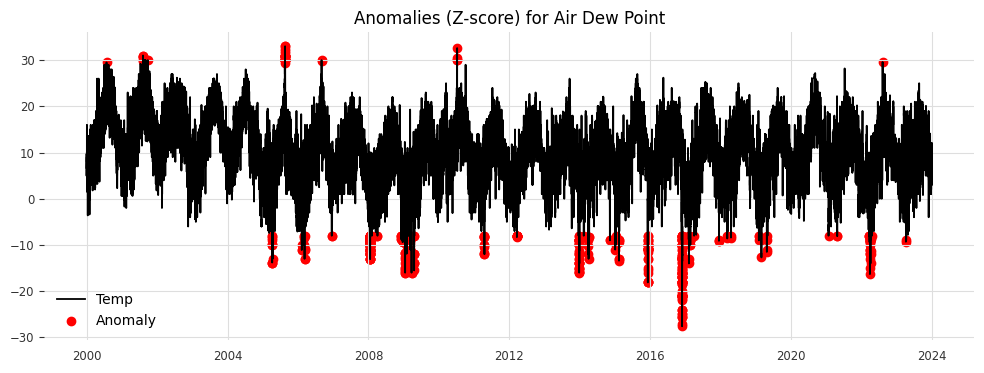

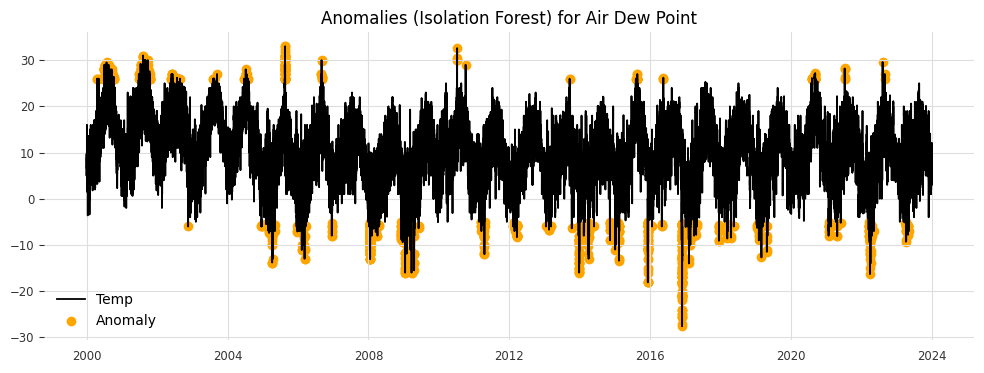

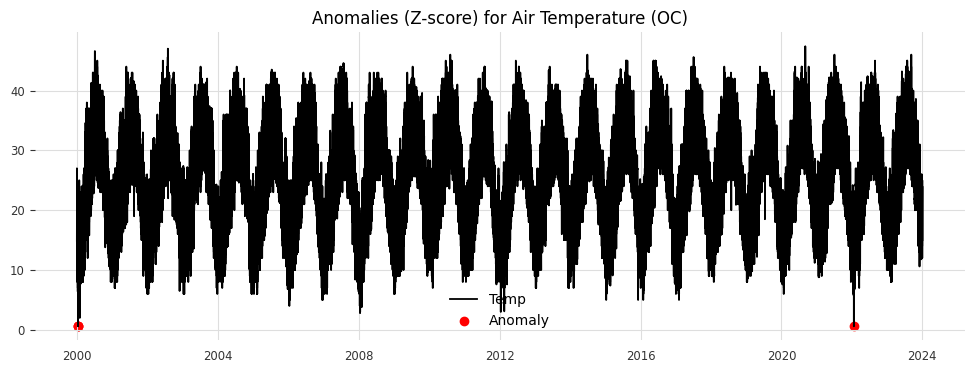

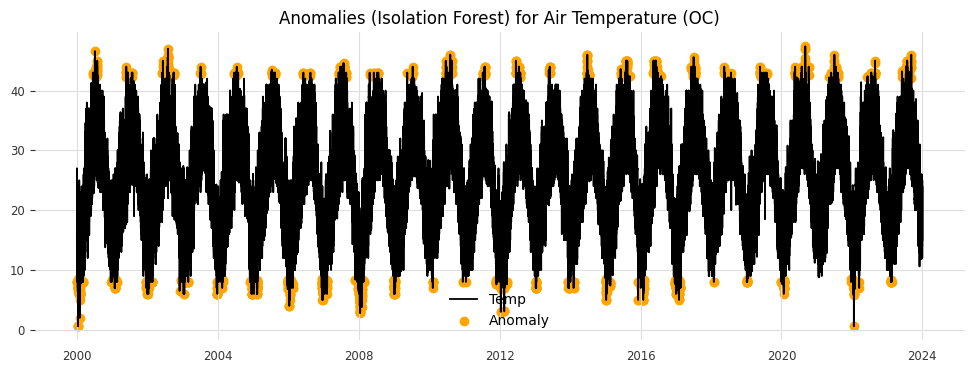

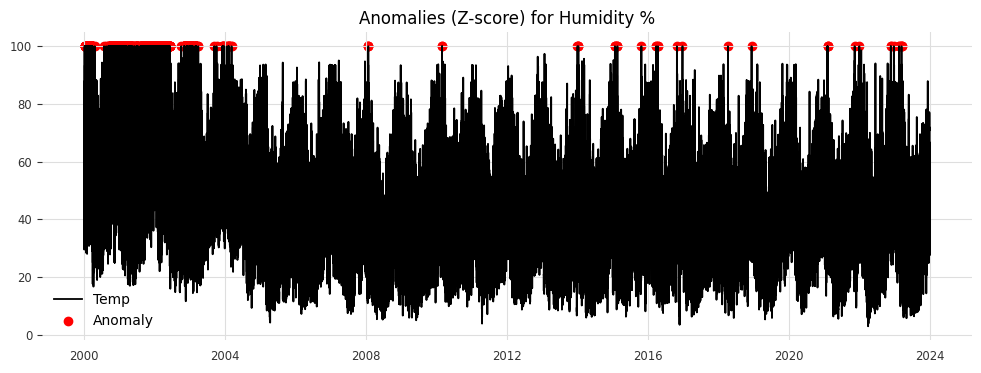

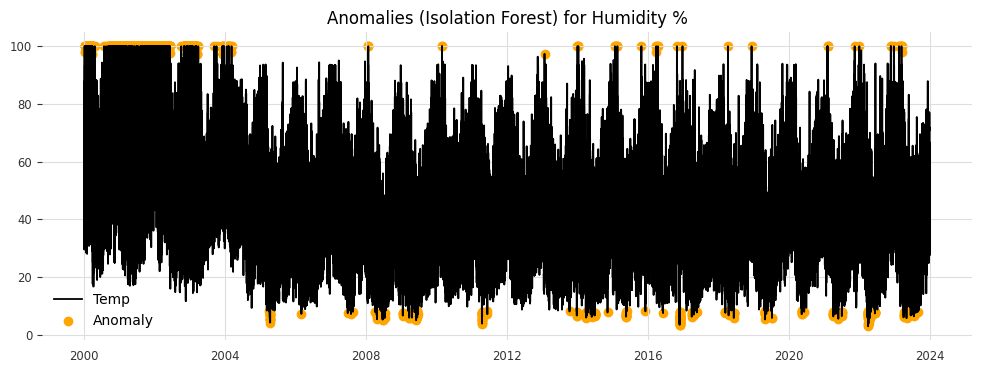

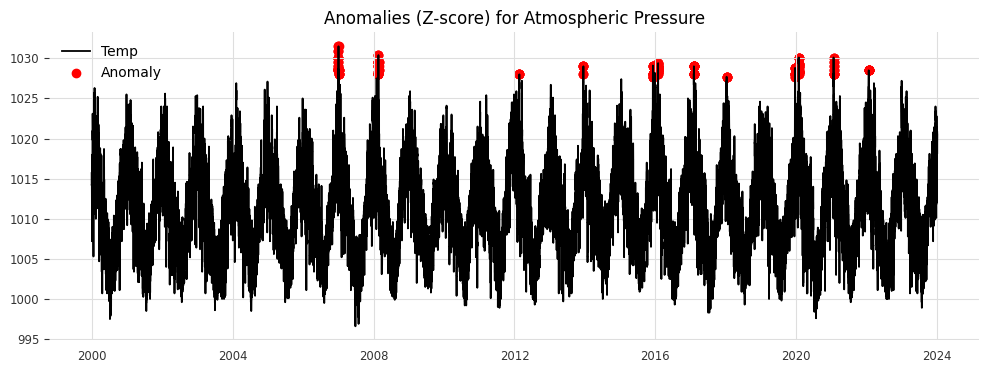

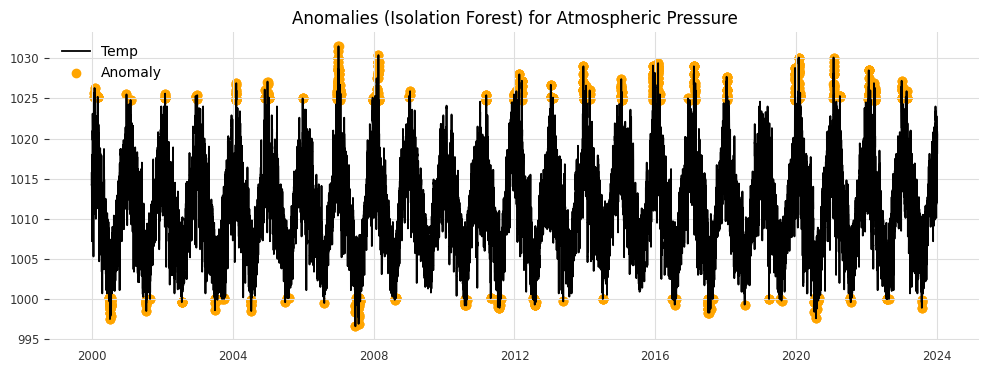

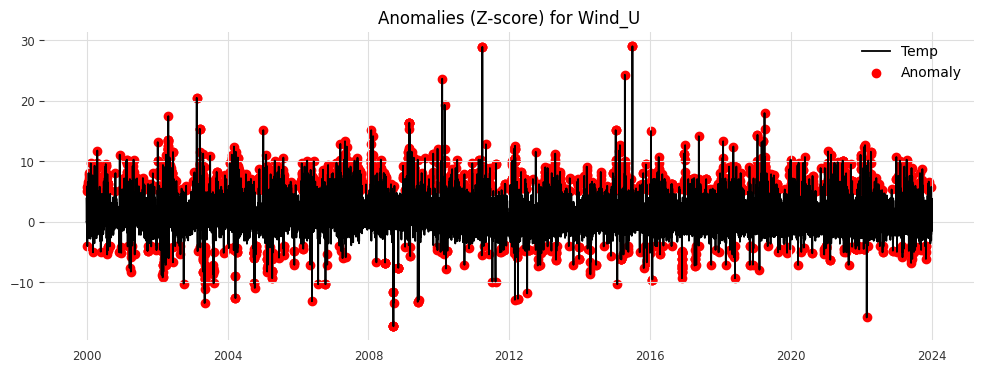

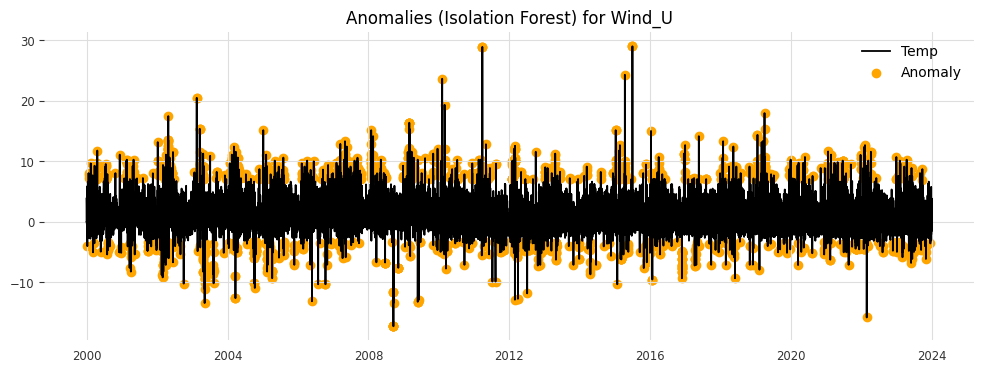

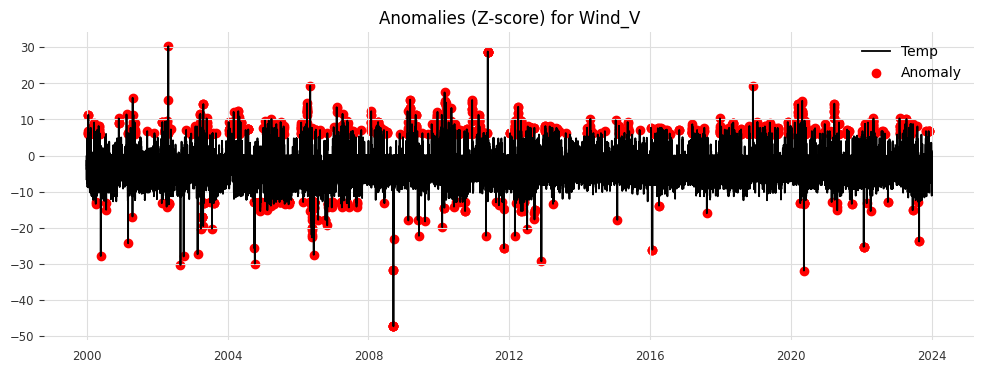

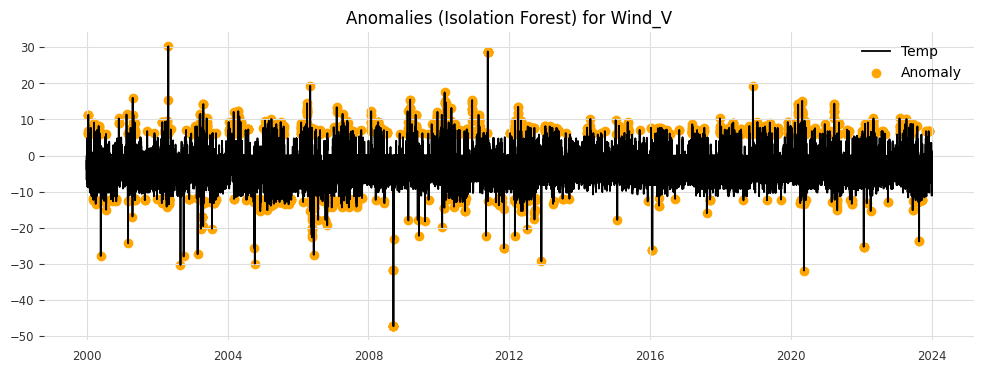

In [46]:
#anomly detection with ML
for col in df.columns:
    z_scores = zscore(df[col].dropna())
    anomalies = np.abs(z_scores) > 3
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[col], label="Temp")
    plt.scatter(df.index[anomalies], df[col][anomalies], color='red', label='Anomaly')
    plt.title(f"Anomalies (Z-score) for {col}")
    plt.legend()
    plt.show()

    iso_df = df[col].dropna()
    iso = IsolationForest(contamination=0.01, random_state=42)
    iso_preds = iso.fit_predict(iso_df.values.reshape(-1, 1))
    iso_anomalies = iso_preds == -1
    plt.figure(figsize=(12, 4))
    plt.plot(iso_df.index, iso_df, label="Temp")
    plt.scatter(iso_df.index[iso_anomalies], iso_df[iso_anomalies], color='orange', label='Anomaly')
    plt.title(f"Anomalies (Isolation Forest) for {col}")
    plt.legend()
    plt.show()

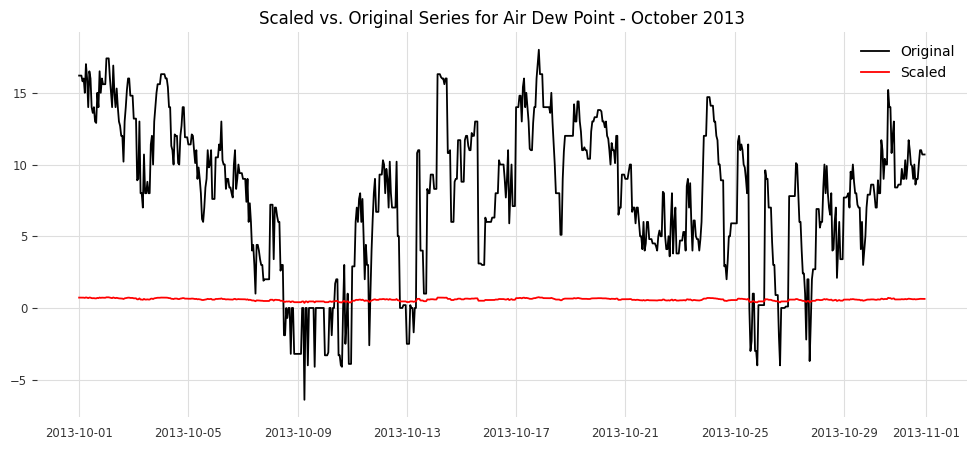

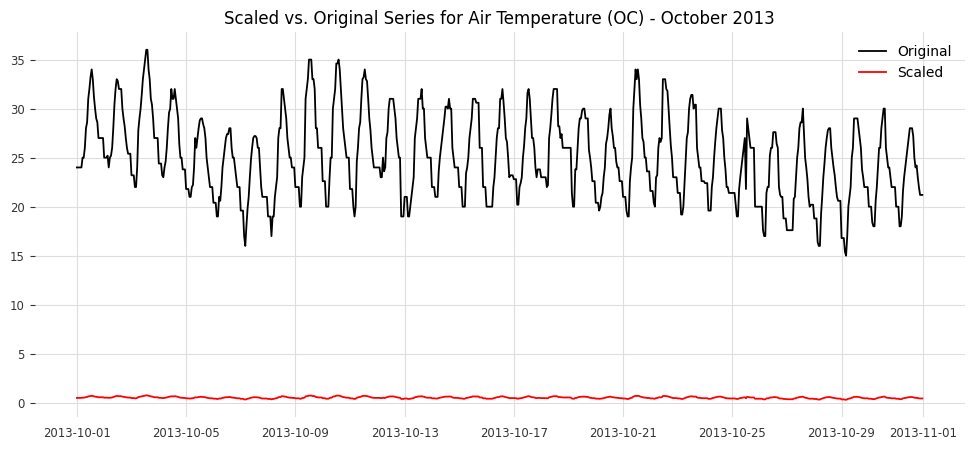

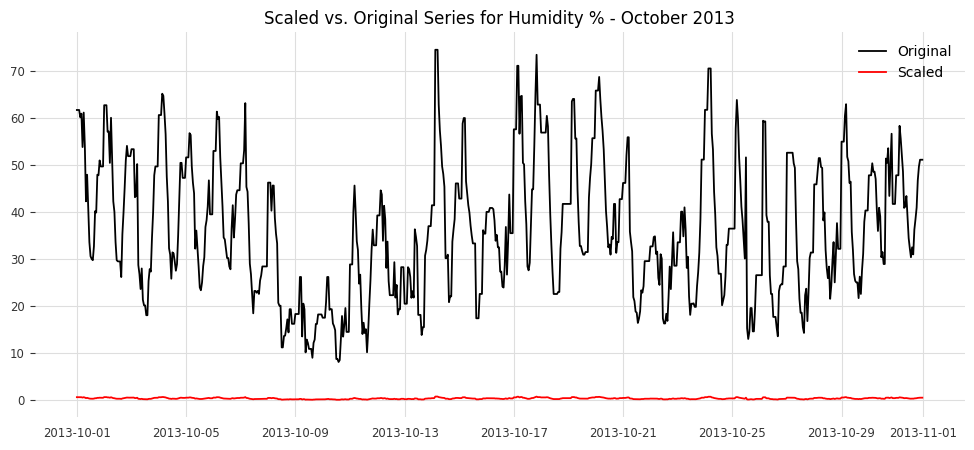

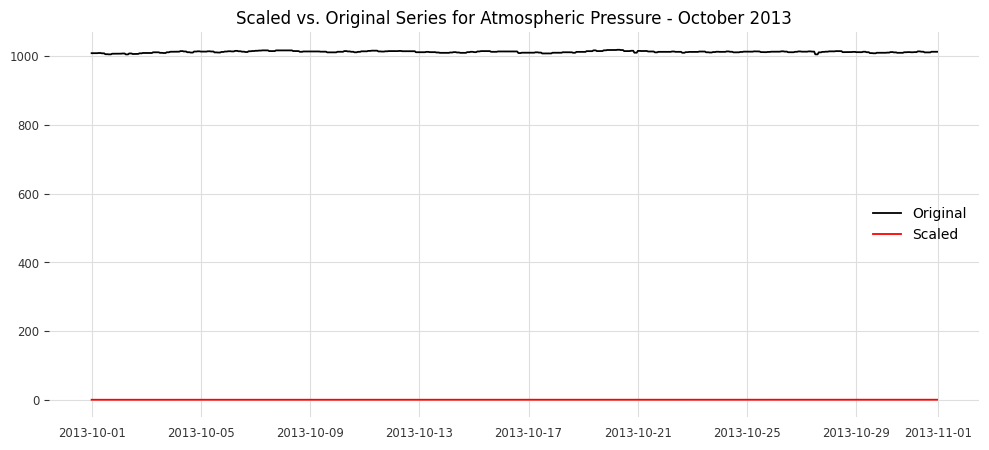

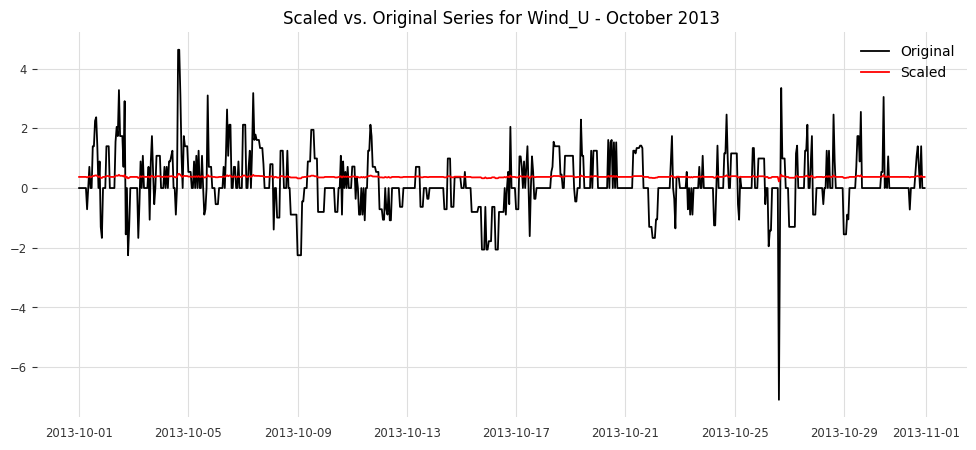

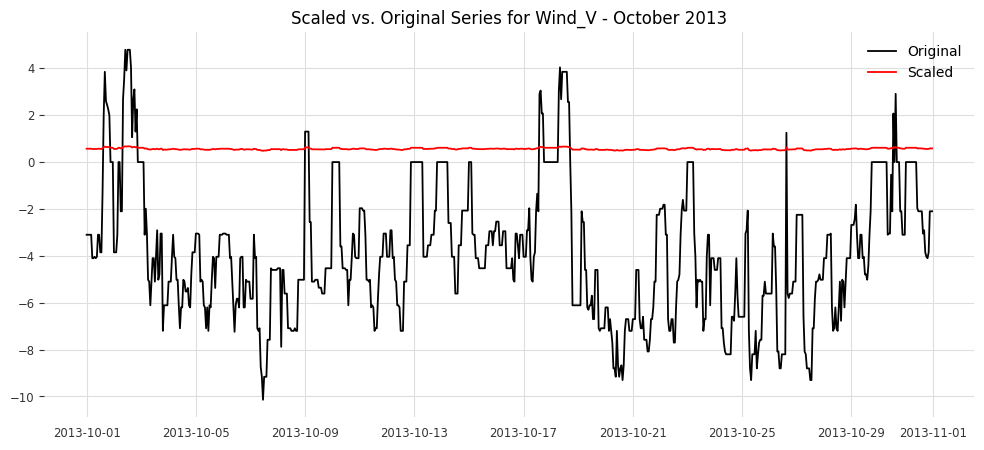

In [ ]:
# series_pd = series.to_dataframe()
# sseries_pd = series_scaled.to_dataframe()

# series_2013_oct = series_pd[(series_pd.index.year == 2013) & (series_pd.index.month == 10)]
# sseries_2013_oct = sseries_pd[(sseries_pd.index.year == 2013) & (sseries_pd.index.month == 10)]

# for col in series_pd.columns:
#     plt.figure(figsize=(12, 5))
#     plt.plot(series_2013_oct.index, series_2013_oct[col], label='Original')
#     plt.plot(sseries_2013_oct.index, sseries_2013_oct[col], label='Scaled', color='red')

#     plt.title(f"Scaled vs. Original Series for {col} - October 2013")
#     plt.legend()
#     plt.grid(True)
#     plt.show()